# Spark data mining

In [2]:
# Must be included at the beginning of each new notebook. Remember to change the app name.
import findspark
findspark.init('/home/ubuntu/spark-3.2.1-bin-hadoop2.7')
import warnings
warnings.simplefilter(action='ignore')
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('readin').getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/10/10 20:31:42 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
# Let's read in the data. Note that it's in the csv

#City,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
#define the schema

# Let's import in the relevant types.
warnings.filterwarnings('ignore')
from pyspark.sql.types import *
Schema=StructType([
  StructField("City",StringType(),nullable=True),
  StructField("Date",StringType(),nullable=True),
  StructField("PM25",FloatType(),nullable=True),
  StructField("PM10",FloatType(),nullable=True),
  StructField("NO",FloatType(),nullable=True),
  StructField("NO2",FloatType(),nullable=True),
  StructField("NOX",FloatType(),nullable=True),
  StructField("NH3",FloatType(),nullable=True),
  StructField("CO",FloatType(),nullable=True),
  StructField("SO2",FloatType(),nullable=True),
  StructField("O3",FloatType(),nullable=True),
  StructField("benzene",FloatType(),nullable=True),
  StructField("toluene",FloatType(),nullable=True),
  StructField("Xylene",FloatType(),nullable=True),
  StructField("AQI",FloatType(),nullable=True),
  StructField("AQIBucket",StringType(),nullable=True)
])
df = spark.read.option("header",True).schema(Schema).csv("Datasets/city_day.csv")

df.show()


+---------+----------+----+----+------+-----+------+----+------+-----+------+-------+-------+------+----+---------+
|     City|      Date|PM25|PM10|    NO|  NO2|   NOX| NH3|    CO|  SO2|    O3|benzene|toluene|Xylene| AQI|AQIBucket|
+---------+----------+----+----+------+-----+------+----+------+-----+------+-------+-------+------+----+---------+
|Ahmedabad|2015-01-01|null|null|  0.92|18.22| 17.15|null|  0.92|27.64|133.36|    0.0|   0.02|   0.0|null|     null|
|Ahmedabad|2015-01-02|null|null|  0.97|15.69| 16.46|null|  0.97|24.55| 34.06|   3.68|    5.5|  3.77|null|     null|
|Ahmedabad|2015-01-03|null|null|  17.4| 19.3|  29.7|null|  17.4|29.07|  30.7|    6.8|   16.4|  2.25|null|     null|
|Ahmedabad|2015-01-04|null|null|   1.7|18.48| 17.97|null|   1.7|18.59| 36.08|   4.43|  10.14|   1.0|null|     null|
|Ahmedabad|2015-01-05|null|null|  22.1|21.42| 37.76|null|  22.1|39.33| 39.31|   7.01|  18.89|  2.78|null|     null|
|Ahmedabad|2015-01-06|null|null| 45.41|38.48|  81.5|null| 45.41|45.76| 4

## Data Exploration

In [4]:
# The show method allows you visualise DataFrames. We can see that there are two columns. 
df.show()

# You could also try this. 
df.columns

df.dtypes

df.describe().toPandas()


+---------+----------+----+----+------+-----+------+----+------+-----+------+-------+-------+------+----+---------+
|     City|      Date|PM25|PM10|    NO|  NO2|   NOX| NH3|    CO|  SO2|    O3|benzene|toluene|Xylene| AQI|AQIBucket|
+---------+----------+----+----+------+-----+------+----+------+-----+------+-------+-------+------+----+---------+
|Ahmedabad|2015-01-01|null|null|  0.92|18.22| 17.15|null|  0.92|27.64|133.36|    0.0|   0.02|   0.0|null|     null|
|Ahmedabad|2015-01-02|null|null|  0.97|15.69| 16.46|null|  0.97|24.55| 34.06|   3.68|    5.5|  3.77|null|     null|
|Ahmedabad|2015-01-03|null|null|  17.4| 19.3|  29.7|null|  17.4|29.07|  30.7|    6.8|   16.4|  2.25|null|     null|
|Ahmedabad|2015-01-04|null|null|   1.7|18.48| 17.97|null|   1.7|18.59| 36.08|   4.43|  10.14|   1.0|null|     null|
|Ahmedabad|2015-01-05|null|null|  22.1|21.42| 37.76|null|  22.1|39.33| 39.31|   7.01|  18.89|  2.78|null|     null|
|Ahmedabad|2015-01-06|null|null| 45.41|38.48|  81.5|null| 45.41|45.76| 4

,summary,City,Date,PM25,PM10,NO,NO2,NOX,NH3,CO,SO2,O3,benzene,toluene,Xylene,AQI,AQIBucket
0,count,29531,29531,24933,18391,25949,25946,25346,19203,27472,25677,25509,23908,21490,11422,24850,24850
1,mean,None,None,67.45057795305125,118.12710294174458,17.574729666828148,28.560659052670943,32.3091233306691,23.483476022437166,2.248598209145695,14.531977259530647,34.49143047007627,3.280840303665094,8.700972087396305,3.0701278206492613,166.4635814889336,None
2,stddev,None,None,64.66144940408857,90.60510976469615,22.785846340154315,24.474745771469095,31.646010951236956,25.68427498752751,6.962884271836143,18.13377486834342,21.694928182946093,15.811136401685069,19.969163666257156,6.323247403424576,140.69658509414992,None
3,min,Ahmedabad,2015-01-01,0.04,0.01,0.02,0.01,0.0,0.01,0.0,0.01,0.01,0.0,0.0,0.0,13.0,Good
4,max,Visakhapatnam,2020-07-01,949.99,1000.0,390.68,362.21,467.63,352.89,175.81,193.86,257.73,455.03,454.85,170.37,2049.0,Very Poor


In [5]:
# We can use the describe method get some general statistics on our data too. Remember to show the DataFrame!
# But what about data type?
# Then create a variable with the correct structure.
df.describe().show()

+-------+-------------+----------+-----------------+------------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+---------+
|summary|         City|      Date|             PM25|              PM10|                NO|               NO2|               NOX|               NH3|               CO|               SO2|                O3|           benzene|           toluene|            Xylene|               AQI|AQIBucket|
+-------+-------------+----------+-----------------+------------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+---------+
|  count|        29531|     29531|            24933|             18391|             25949|             25946|             25346|  

In [6]:
# For type, we can use print schema. 
# But wait! What if you want to change the format of the data? Maybe change age to an integer instead of long?
# And now we can read in the data using that schema. If we print the schema, we can see that age is now an integer.
df.printSchema()

root
 |-- City: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- PM25: float (nullable = true)
 |-- PM10: float (nullable = true)
 |-- NO: float (nullable = true)
 |-- NO2: float (nullable = true)
 |-- NOX: float (nullable = true)
 |-- NH3: float (nullable = true)
 |-- CO: float (nullable = true)
 |-- SO2: float (nullable = true)
 |-- O3: float (nullable = true)
 |-- benzene: float (nullable = true)
 |-- toluene: float (nullable = true)
 |-- Xylene: float (nullable = true)
 |-- AQI: float (nullable = true)
 |-- AQIBucket: string (nullable = true)



## Data Manipulation

In [7]:
df.describe().toPandas()

df.groupby('AQIBucket').count().show()


+------------+-----+
|   AQIBucket|count|
+------------+-----+
|        null| 4681|
|        Good| 1341|
|      Severe| 1338|
|   Very Poor| 2337|
|Satisfactory| 8224|
|        Poor| 2781|
|    Moderate| 8829|
+------------+-----+



In [8]:

df.groupby('City').count().show()

+------------------+-----+
|              City|count|
+------------------+-----+
|             Kochi|  162|
|             Patna| 1858|
|         Ernakulam|  162|
|           Chennai| 2009|
|           Lucknow| 2009|
|            Mumbai| 2009|
|            Aizawl|  113|
|         Ahmedabad| 2009|
|          Gurugram| 1679|
|      Brajrajnagar|  938|
|           Kolkata|  814|
|         Amaravati|  951|
|          Amritsar| 1221|
|          Shillong|  310|
|             Delhi| 2009|
|        Chandigarh|  304|
|        Coimbatore|  386|
|            Bhopal|  289|
|Thiruvananthapuram| 1112|
|         Bengaluru| 2009|
+------------------+-----+
only showing top 20 rows



In [9]:
df.count()
# Let's see the data. You'll notice nulls.
df.show()

+---------+----------+----+----+------+-----+------+----+------+-----+------+-------+-------+------+----+---------+
|     City|      Date|PM25|PM10|    NO|  NO2|   NOX| NH3|    CO|  SO2|    O3|benzene|toluene|Xylene| AQI|AQIBucket|
+---------+----------+----+----+------+-----+------+----+------+-----+------+-------+-------+------+----+---------+
|Ahmedabad|2015-01-01|null|null|  0.92|18.22| 17.15|null|  0.92|27.64|133.36|    0.0|   0.02|   0.0|null|     null|
|Ahmedabad|2015-01-02|null|null|  0.97|15.69| 16.46|null|  0.97|24.55| 34.06|   3.68|    5.5|  3.77|null|     null|
|Ahmedabad|2015-01-03|null|null|  17.4| 19.3|  29.7|null|  17.4|29.07|  30.7|    6.8|   16.4|  2.25|null|     null|
|Ahmedabad|2015-01-04|null|null|   1.7|18.48| 17.97|null|   1.7|18.59| 36.08|   4.43|  10.14|   1.0|null|     null|
|Ahmedabad|2015-01-05|null|null|  22.1|21.42| 37.76|null|  22.1|39.33| 39.31|   7.01|  18.89|  2.78|null|     null|
|Ahmedabad|2015-01-06|null|null| 45.41|38.48|  81.5|null| 45.41|45.76| 4

In [10]:
# First, we have to register the DataFrame as a SQL temporary view.
df.createOrReplaceTempView('pollution')

# After that, we can use the SQL programming language for queries. 
results = spark.sql("SELECT * FROM pollution")
results.show()

+---------+----------+----+----+------+-----+------+----+------+-----+------+-------+-------+------+----+---------+
|     City|      Date|PM25|PM10|    NO|  NO2|   NOX| NH3|    CO|  SO2|    O3|benzene|toluene|Xylene| AQI|AQIBucket|
+---------+----------+----+----+------+-----+------+----+------+-----+------+-------+-------+------+----+---------+
|Ahmedabad|2015-01-01|null|null|  0.92|18.22| 17.15|null|  0.92|27.64|133.36|    0.0|   0.02|   0.0|null|     null|
|Ahmedabad|2015-01-02|null|null|  0.97|15.69| 16.46|null|  0.97|24.55| 34.06|   3.68|    5.5|  3.77|null|     null|
|Ahmedabad|2015-01-03|null|null|  17.4| 19.3|  29.7|null|  17.4|29.07|  30.7|    6.8|   16.4|  2.25|null|     null|
|Ahmedabad|2015-01-04|null|null|   1.7|18.48| 17.97|null|   1.7|18.59| 36.08|   4.43|  10.14|   1.0|null|     null|
|Ahmedabad|2015-01-05|null|null|  22.1|21.42| 37.76|null|  22.1|39.33| 39.31|   7.01|  18.89|  2.78|null|     null|
|Ahmedabad|2015-01-06|null|null| 45.41|38.48|  81.5|null| 45.41|45.76| 4

In [11]:
# After that, we can use the SQL programming language for queries. 
results1 = spark.sql("SELECT city, count(City) FROM pollution where AQI is null group by City")
results1.show()

+------------------+-----------+
|              city|count(City)|
+------------------+-----------+
|             Kochi|          4|
|             Patna|        399|
|         Ernakulam|          9|
|           Chennai|        125|
|           Lucknow|        116|
|            Mumbai|       1234|
|            Aizawl|          2|
|         Ahmedabad|        675|
|          Gurugram|        226|
|      Brajrajnagar|        225|
|           Kolkata|         60|
|         Amaravati|        110|
|          Amritsar|         95|
|          Shillong|        105|
|             Delhi|         10|
|        Chandigarh|          5|
|        Coimbatore|         42|
|            Bhopal|         11|
|Thiruvananthapuram|         60|
|         Bengaluru|         99|
+------------------+-----------+
only showing top 20 rows



In [12]:
# Find count for empty, None, Null, Nan with string literals.
from pyspark.sql.functions import col,isnan,when,count
df2 = df.select([count(when(col(c).contains('None') | \
                            col(c).contains('NULL') | \
                            (col(c) == '' ) | \
                            col(c).isNull() | \
                            isnan(c), c 
                           )).alias(c)
                    for c in df.columns])
df2.show()

+----+----+----+-----+----+----+----+-----+----+----+----+-------+-------+------+----+---------+
|City|Date|PM25| PM10|  NO| NO2| NOX|  NH3|  CO| SO2|  O3|benzene|toluene|Xylene| AQI|AQIBucket|
+----+----+----+-----+----+----+----+-----+----+----+----+-------+-------+------+----+---------+
|   0|   0|4598|11140|3582|3585|4185|10328|2059|3854|4022|   5623|   8041| 18109|4681|     4681|
+----+----+----+-----+----+----+----+-----+----+----+----+-------+-------+------+----+---------+



In [13]:
from pyspark.sql.functions import isnan, when, count, col

df.select([count(when(isnan(c), c)).alias(c) for c in df.columns]).show()

+----+----+----+----+---+---+---+---+---+---+---+-------+-------+------+---+---------+
|City|Date|PM25|PM10| NO|NO2|NOX|NH3| CO|SO2| O3|benzene|toluene|Xylene|AQI|AQIBucket|
+----+----+----+----+---+---+---+---+---+---+---+-------+-------+------+---+---------+
|   0|   0|   0|   0|  0|  0|  0|  0|  0|  0|  0|      0|      0|     0|  0|        0|
+----+----+----+----+---+---+---+---+---+---+---+-------+-------+------+---+---------+



# Exploring data with SQL

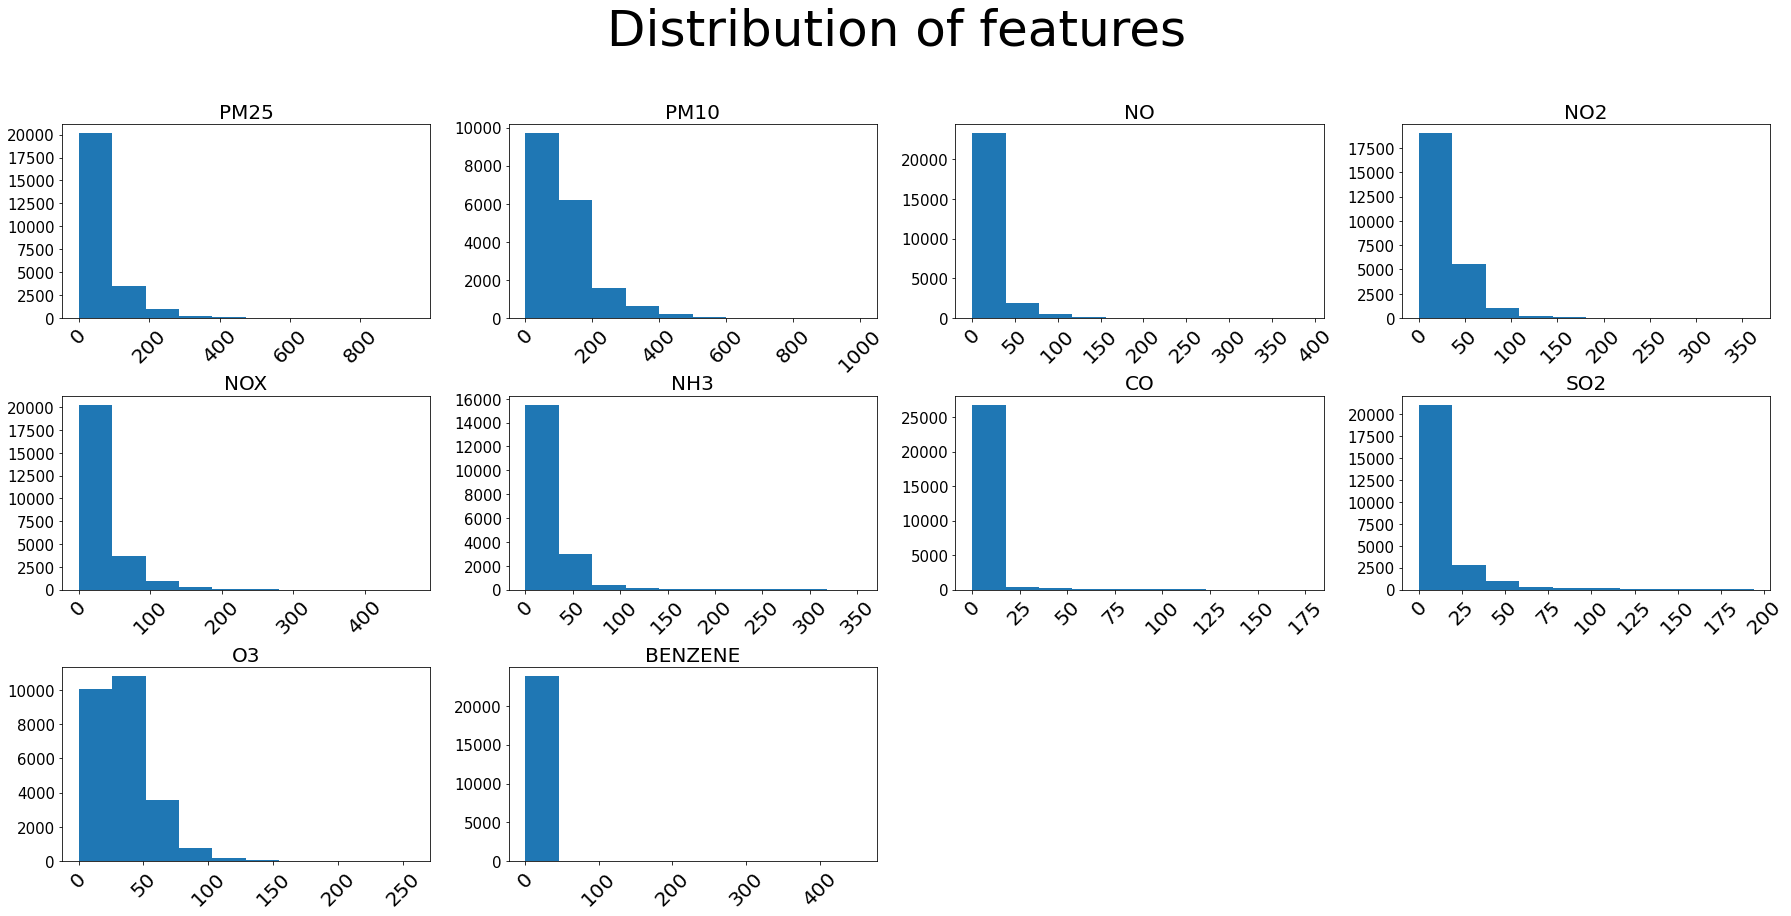

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore')

fig = plt.figure(figsize=(25,13))
st = fig.suptitle("Distribution of features",fontsize = 50, verticalalignment="center")
for col,num in zip(df.toPandas().describe().columns, range(1,11)):
    ax = fig.add_subplot(3,4, num)
    ax.hist(df.toPandas()[col])
    plt.grid(False)
    plt.xticks(rotation=45, fontsize=20)
    plt.yticks(fontsize=15)
    plt.title(col.upper(), fontsize=20)

plt.tight_layout()
st.set_y(0.95)
fig.subplots_adjust(top=0.85, hspace=0.4)
plt.show()

In [15]:
#Import all the required functions
from pyspark.sql.functions import year 
df.createOrReplaceTempView('pollution')

results1 = spark.sql("SELECT city, Count(AQIBucket), count(City) FROM pollution where AQIBucket is not null group by City, AQIBucket")
results1.show()


+------------------+----------------+-----------+
|              city|count(AQIBucket)|count(City)|
+------------------+----------------+-----------+
|         Hyderabad|             141|        141|
|           Kolkata|             119|        119|
|          Guwahati|             111|        111|
|          Gurugram|             454|        454|
|             Kochi|              74|         74|
|             Kochi|               2|          2|
|Thiruvananthapuram|             154|        154|
|             Delhi|             542|        542|
|     Visakhapatnam|              52|         52|
|            Bhopal|             165|        165|
|     Visakhapatnam|             580|        580|
|          Shillong|              10|         10|
|         Ahmedabad|             238|        238|
|            Mumbai|              26|         26|
|           Lucknow|             473|        473|
|          Guwahati|             135|        135|
|         Ernakulam|              49|         49|


In [16]:
# Requires a certain amount of non-null values. Row two was dropped, as there's only one non-null value.
df.na.drop(thresh=8).show()

+---------+----------+----+----+------+-----+------+----+------+-----+------+-------+-------+------+----+---------+
|     City|      Date|PM25|PM10|    NO|  NO2|   NOX| NH3|    CO|  SO2|    O3|benzene|toluene|Xylene| AQI|AQIBucket|
+---------+----------+----+----+------+-----+------+----+------+-----+------+-------+-------+------+----+---------+
|Ahmedabad|2015-01-01|null|null|  0.92|18.22| 17.15|null|  0.92|27.64|133.36|    0.0|   0.02|   0.0|null|     null|
|Ahmedabad|2015-01-02|null|null|  0.97|15.69| 16.46|null|  0.97|24.55| 34.06|   3.68|    5.5|  3.77|null|     null|
|Ahmedabad|2015-01-03|null|null|  17.4| 19.3|  29.7|null|  17.4|29.07|  30.7|    6.8|   16.4|  2.25|null|     null|
|Ahmedabad|2015-01-04|null|null|   1.7|18.48| 17.97|null|   1.7|18.59| 36.08|   4.43|  10.14|   1.0|null|     null|
|Ahmedabad|2015-01-05|null|null|  22.1|21.42| 37.76|null|  22.1|39.33| 39.31|   7.01|  18.89|  2.78|null|     null|
|Ahmedabad|2015-01-06|null|null| 45.41|38.48|  81.5|null| 45.41|45.76| 4

In [17]:
df.count()

29531

In [18]:
import sys
###backward fill
from pyspark.sql import Window
from pyspark.sql.functions import first,last

# define the window
window = Window.partitionBy('City')\
               .orderBy('Date')\
               .rowsBetween(0, sys.maxsize)

# define the forward-filled column
filled_column = first(df['PM25'], ignorenulls=True).over(window)

# do the fill
spark_df_filled = df.withColumn('PM25', filled_column)

# show off our glorious achievements
spark_df_filled.orderBy('City', 'Date').show(10) 
spark_df_filled.show()

# define the window
window = Window.partitionBy('City')\
               .orderBy('Date')\
               .rowsBetween(-sys.maxsize,0)

# define the forward-filled column
filled_column = last(spark_df_filled['PM25'], ignorenulls=True).over(window)

# do the fill
spark_df_filled = spark_df_filled.withColumn('PM25', filled_column)
# show off our glorious achievements

spark_df_filled.orderBy('City', 'Date').show(10) 
spark_df_filled.show()


+---------+----------+-----+----+------+-----+------+----+------+-----+------+-------+-------+------+----+---------+
|     City|      Date| PM25|PM10|    NO|  NO2|   NOX| NH3|    CO|  SO2|    O3|benzene|toluene|Xylene| AQI|AQIBucket|
+---------+----------+-----+----+------+-----+------+----+------+-----+------+-------+-------+------+----+---------+
|Ahmedabad|2015-01-01|73.24|null|  0.92|18.22| 17.15|null|  0.92|27.64|133.36|    0.0|   0.02|   0.0|null|     null|
|Ahmedabad|2015-01-02|73.24|null|  0.97|15.69| 16.46|null|  0.97|24.55| 34.06|   3.68|    5.5|  3.77|null|     null|
|Ahmedabad|2015-01-03|73.24|null|  17.4| 19.3|  29.7|null|  17.4|29.07|  30.7|    6.8|   16.4|  2.25|null|     null|
|Ahmedabad|2015-01-04|73.24|null|   1.7|18.48| 17.97|null|   1.7|18.59| 36.08|   4.43|  10.14|   1.0|null|     null|
|Ahmedabad|2015-01-05|73.24|null|  22.1|21.42| 37.76|null|  22.1|39.33| 39.31|   7.01|  18.89|  2.78|null|     null|
|Ahmedabad|2015-01-06|73.24|null| 45.41|38.48|  81.5|null| 45.41

+---------+----------+-----+----+------+-----+------+----+------+-----+------+-------+-------+------+----+---------+
|     City|      Date| PM25|PM10|    NO|  NO2|   NOX| NH3|    CO|  SO2|    O3|benzene|toluene|Xylene| AQI|AQIBucket|
+---------+----------+-----+----+------+-----+------+----+------+-----+------+-------+-------+------+----+---------+
|Ahmedabad|2015-01-01|73.24|null|  0.92|18.22| 17.15|null|  0.92|27.64|133.36|    0.0|   0.02|   0.0|null|     null|
|Ahmedabad|2015-01-02|73.24|null|  0.97|15.69| 16.46|null|  0.97|24.55| 34.06|   3.68|    5.5|  3.77|null|     null|
|Ahmedabad|2015-01-03|73.24|null|  17.4| 19.3|  29.7|null|  17.4|29.07|  30.7|    6.8|   16.4|  2.25|null|     null|
|Ahmedabad|2015-01-04|73.24|null|   1.7|18.48| 17.97|null|   1.7|18.59| 36.08|   4.43|  10.14|   1.0|null|     null|
|Ahmedabad|2015-01-05|73.24|null|  22.1|21.42| 37.76|null|  22.1|39.33| 39.31|   7.01|  18.89|  2.78|null|     null|
|Ahmedabad|2015-01-06|73.24|null| 45.41|38.48|  81.5|null| 45.41

In [19]:
spark_df_filled.filter(spark_df_filled.PM25.isNull()).show()

+----+----+----+----+---+---+---+---+---+---+---+-------+-------+------+---+---------+
|City|Date|PM25|PM10| NO|NO2|NOX|NH3| CO|SO2| O3|benzene|toluene|Xylene|AQI|AQIBucket|
+----+----+----+----+---+---+---+---+---+---+---+-------+-------+------+---+---------+
+----+----+----+----+---+---+---+---+---+---+---+-------+-------+------+---+---------+



In [20]:
# Find count for empty, None, Null, Nan with string literals.
from pyspark.sql.functions import col,isnan,when,count
df2 = spark_df_filled
df2 = df2.select([count(when(col(c).contains('None') | \
                            col(c).contains('NULL') | \
                            (col(c) == '' ) | \
                            col(c).isNull() | \
                            isnan(c), c 
                           )).alias(c)
                    for c in df2.columns])
df2.show()

+----+----+----+-----+----+----+----+-----+----+----+----+-------+-------+------+----+---------+
|City|Date|PM25| PM10|  NO| NO2| NOX|  NH3|  CO| SO2|  O3|benzene|toluene|Xylene| AQI|AQIBucket|
+----+----+----+-----+----+----+----+-----+----+----+----+-------+-------+------+----+---------+
|   0|   0|   0|11140|3582|3585|4185|10328|2059|3854|4022|   5623|   8041| 18109|4681|     4681|
+----+----+----+-----+----+----+----+-----+----+----+----+-------+-------+------+----+---------+



In [21]:
import sys
###backward fill
from pyspark.sql import Window
from pyspark.sql.functions import last, first

# define the window
window = Window.partitionBy('City')\
               .orderBy('Date')\
               .rowsBetween(-sys.maxsize , 0)

# define the forward-filled column
filled_column = last(spark_df_filled['PM10'], ignorenulls=True).over(window)

# do the fill
spark_df_filled = spark_df_filled.withColumn('PM10', filled_column)

# show off our glorious achievements
spark_df_filled.orderBy('City', 'Date').show(10) 
spark_df_filled.show()



# define the window
window = Window.partitionBy('City')\
               .orderBy('Date')\
               .rowsBetween(0, sys.maxsize)

# define the forward-filled column
filled_column= first(spark_df_filled['PM10'], ignorenulls=True).over(window)

# do the fill
spark_df_filled = spark_df_filled.withColumn('PM10', filled_column)

# show off our glorious achievements
spark_df_filled.orderBy('City', 'Date').show(10) 
spark_df_filled.show()

+---------+----------+-----+----+------+-----+------+----+------+-----+------+-------+-------+------+----+---------+
|     City|      Date| PM25|PM10|    NO|  NO2|   NOX| NH3|    CO|  SO2|    O3|benzene|toluene|Xylene| AQI|AQIBucket|
+---------+----------+-----+----+------+-----+------+----+------+-----+------+-------+-------+------+----+---------+
|Ahmedabad|2015-01-01|73.24|null|  0.92|18.22| 17.15|null|  0.92|27.64|133.36|    0.0|   0.02|   0.0|null|     null|
|Ahmedabad|2015-01-02|73.24|null|  0.97|15.69| 16.46|null|  0.97|24.55| 34.06|   3.68|    5.5|  3.77|null|     null|
|Ahmedabad|2015-01-03|73.24|null|  17.4| 19.3|  29.7|null|  17.4|29.07|  30.7|    6.8|   16.4|  2.25|null|     null|
|Ahmedabad|2015-01-04|73.24|null|   1.7|18.48| 17.97|null|   1.7|18.59| 36.08|   4.43|  10.14|   1.0|null|     null|
|Ahmedabad|2015-01-05|73.24|null|  22.1|21.42| 37.76|null|  22.1|39.33| 39.31|   7.01|  18.89|  2.78|null|     null|
|Ahmedabad|2015-01-06|73.24|null| 45.41|38.48|  81.5|null| 45.41

+---------+----------+-----+------+------+-----+------+----+------+-----+------+-------+-------+------+----+---------+
|     City|      Date| PM25|  PM10|    NO|  NO2|   NOX| NH3|    CO|  SO2|    O3|benzene|toluene|Xylene| AQI|AQIBucket|
+---------+----------+-----+------+------+-----+------+----+------+-----+------+-------+-------+------+----+---------+
|Ahmedabad|2015-01-01|73.24|141.54|  0.92|18.22| 17.15|null|  0.92|27.64|133.36|    0.0|   0.02|   0.0|null|     null|
|Ahmedabad|2015-01-02|73.24|141.54|  0.97|15.69| 16.46|null|  0.97|24.55| 34.06|   3.68|    5.5|  3.77|null|     null|
|Ahmedabad|2015-01-03|73.24|141.54|  17.4| 19.3|  29.7|null|  17.4|29.07|  30.7|    6.8|   16.4|  2.25|null|     null|
|Ahmedabad|2015-01-04|73.24|141.54|   1.7|18.48| 17.97|null|   1.7|18.59| 36.08|   4.43|  10.14|   1.0|null|     null|
|Ahmedabad|2015-01-05|73.24|141.54|  22.1|21.42| 37.76|null|  22.1|39.33| 39.31|   7.01|  18.89|  2.78|null|     null|
|Ahmedabad|2015-01-06|73.24|141.54| 45.41|38.48|

In [22]:
# First, we have to register the DataFrame as a SQL temporary view.

dff= spark_df_filled
dff.createOrReplaceTempView('pollution')

results = spark.sql("SELECT * FROM pollution where pm10 is null")
results.show()

+-------+----------+------+----+----+-----+----+----+-----+------+-----+-------+-------+------+----+---------+
|   City|      Date|  PM25|PM10|  NO|  NO2| NOX| NH3|   CO|   SO2|   O3|benzene|toluene|Xylene| AQI|AQIBucket|
+-------+----------+------+----+----+-----+----+----+-----+------+-----+-------+-------+------+----+---------+
|Lucknow|2015-01-01|742.67|null|2.11|13.46|4.57|null|12.15|169.57|25.92|   1.35|   3.93|  null|null|     null|
|Lucknow|2015-01-02|742.67|null|2.37|10.76| 3.8|null| 14.0|169.46|21.66|   1.97|   5.74|  null|null|     null|
|Lucknow|2015-01-03|742.67|null|2.27|12.43|4.22|null|12.78|169.77| 22.4|   1.83|   4.76|  null|null|     null|
|Lucknow|2015-01-04|742.67|null|2.24|12.46|4.22|null|11.85|169.56|21.41|   2.27|   4.77|  null|null|     null|
|Lucknow|2015-01-05|742.67|null|2.32|12.27|4.22|null|13.34|169.48| 20.6|   2.49|   4.78|  null|null|     null|
|Lucknow|2015-01-06|742.67|null|2.33|12.91| 4.3|null|14.21|178.63|21.49|   2.93|    4.6|  null|null|     null|
|

In [23]:
dff.filter(dff.PM10.isNull()).show()

+-------+----------+------+----+----+-----+----+----+-----+------+-----+-------+-------+------+----+---------+
|   City|      Date|  PM25|PM10|  NO|  NO2| NOX| NH3|   CO|   SO2|   O3|benzene|toluene|Xylene| AQI|AQIBucket|
+-------+----------+------+----+----+-----+----+----+-----+------+-----+-------+-------+------+----+---------+
|Lucknow|2015-01-01|742.67|null|2.11|13.46|4.57|null|12.15|169.57|25.92|   1.35|   3.93|  null|null|     null|
|Lucknow|2015-01-02|742.67|null|2.37|10.76| 3.8|null| 14.0|169.46|21.66|   1.97|   5.74|  null|null|     null|
|Lucknow|2015-01-03|742.67|null|2.27|12.43|4.22|null|12.78|169.77| 22.4|   1.83|   4.76|  null|null|     null|
|Lucknow|2015-01-04|742.67|null|2.24|12.46|4.22|null|11.85|169.56|21.41|   2.27|   4.77|  null|null|     null|
|Lucknow|2015-01-05|742.67|null|2.32|12.27|4.22|null|13.34|169.48| 20.6|   2.49|   4.78|  null|null|     null|
|Lucknow|2015-01-06|742.67|null|2.33|12.91| 4.3|null|14.21|178.63|21.49|   2.93|    4.6|  null|null|     null|
|

In [24]:
from pyspark.sql.functions import mean
mean_pm10 = dff.select(mean(dff['PM10'])).collect()
mean_pm10[0][0]


122.20046297371947

In [25]:


dff1 = dff.na.fill(mean_pm10[0][0], subset=['PM10'])
dff1.filter(dff1.PM10.isNull()).show()

+----+----+----+----+---+---+---+---+---+---+---+-------+-------+------+---+---------+
|City|Date|PM25|PM10| NO|NO2|NOX|NH3| CO|SO2| O3|benzene|toluene|Xylene|AQI|AQIBucket|
+----+----+----+----+---+---+---+---+---+---+---+-------+-------+------+---+---------+
+----+----+----+----+---+---+---+---+---+---+---+-------+-------+------+---+---------+



In [26]:
dff1.show()

+---------+----------+-----+------+------+-----+------+----+------+-----+------+-------+-------+------+----+---------+
|     City|      Date| PM25|  PM10|    NO|  NO2|   NOX| NH3|    CO|  SO2|    O3|benzene|toluene|Xylene| AQI|AQIBucket|
+---------+----------+-----+------+------+-----+------+----+------+-----+------+-------+-------+------+----+---------+
|Ahmedabad|2015-01-01|73.24|141.54|  0.92|18.22| 17.15|null|  0.92|27.64|133.36|    0.0|   0.02|   0.0|null|     null|
|Ahmedabad|2015-01-02|73.24|141.54|  0.97|15.69| 16.46|null|  0.97|24.55| 34.06|   3.68|    5.5|  3.77|null|     null|
|Ahmedabad|2015-01-03|73.24|141.54|  17.4| 19.3|  29.7|null|  17.4|29.07|  30.7|    6.8|   16.4|  2.25|null|     null|
|Ahmedabad|2015-01-04|73.24|141.54|   1.7|18.48| 17.97|null|   1.7|18.59| 36.08|   4.43|  10.14|   1.0|null|     null|
|Ahmedabad|2015-01-05|73.24|141.54|  22.1|21.42| 37.76|null|  22.1|39.33| 39.31|   7.01|  18.89|  2.78|null|     null|
|Ahmedabad|2015-01-06|73.24|141.54| 45.41|38.48|

In [27]:

#dff.filter(dff.PM25.isNull()).show()
#from pyspark.sql.functions import isnan, when, count, col

#dff.select([count(when(isNull(c), c)).alias(c) for c in dff.columns]).show()

# Find count for empty, None, Null, Nan with string literals.
from pyspark.sql.functions import col,isnan,when,count

dffs = dff1.select([count(when(col(c).contains('None') | \
                            col(c).contains('NULL') | \
                            (col(c) == '' ) | \
                            col(c).isNull() | \
                            isnan(c), c 
                           )).alias(c)
                    for c in dff.columns])
dffs.show()

+----+----+----+----+----+----+----+-----+----+----+----+-------+-------+------+----+---------+
|City|Date|PM25|PM10|  NO| NO2| NOX|  NH3|  CO| SO2|  O3|benzene|toluene|Xylene| AQI|AQIBucket|
+----+----+----+----+----+----+----+-----+----+----+----+-------+-------+------+----+---------+
|   0|   0|   0|   0|3582|3585|4185|10328|2059|3854|4022|   5623|   8041| 18109|4681|     4681|
+----+----+----+----+----+----+----+-----+----+----+----+-------+-------+------+----+---------+



In [28]:
# To Get Year from date or Time column
spark_df_filled = dff1
spark_df_filled1 = spark_df_filled.withColumn("year",year("Date"))


In [29]:
dff2= spark_df_filled1
dff2.show()



+---------+----------+-----+------+------+-----+------+----+------+-----+------+-------+-------+------+----+---------+----+
|     City|      Date| PM25|  PM10|    NO|  NO2|   NOX| NH3|    CO|  SO2|    O3|benzene|toluene|Xylene| AQI|AQIBucket|year|
+---------+----------+-----+------+------+-----+------+----+------+-----+------+-------+-------+------+----+---------+----+
|Ahmedabad|2015-01-01|73.24|141.54|  0.92|18.22| 17.15|null|  0.92|27.64|133.36|    0.0|   0.02|   0.0|null|     null|2015|
|Ahmedabad|2015-01-02|73.24|141.54|  0.97|15.69| 16.46|null|  0.97|24.55| 34.06|   3.68|    5.5|  3.77|null|     null|2015|
|Ahmedabad|2015-01-03|73.24|141.54|  17.4| 19.3|  29.7|null|  17.4|29.07|  30.7|    6.8|   16.4|  2.25|null|     null|2015|
|Ahmedabad|2015-01-04|73.24|141.54|   1.7|18.48| 17.97|null|   1.7|18.59| 36.08|   4.43|  10.14|   1.0|null|     null|2015|
|Ahmedabad|2015-01-05|73.24|141.54|  22.1|21.42| 37.76|null|  22.1|39.33| 39.31|   7.01|  18.89|  2.78|null|     null|2015|
|Ahmedab

In [30]:
dff2.createOrReplaceTempView('pollution')

results = spark.sql("SELECT * FROM pollution where PM10 is null")
results.show()

+----+----+----+----+---+---+---+---+---+---+---+-------+-------+------+---+---------+----+
|City|Date|PM25|PM10| NO|NO2|NOX|NH3| CO|SO2| O3|benzene|toluene|Xylene|AQI|AQIBucket|year|
+----+----+----+----+---+---+---+---+---+---+---+-------+-------+------+---+---------+----+
+----+----+----+----+---+---+---+---+---+---+---+-------+-------+------+---+---------+----+



In [31]:
dff2.count()
dff2.show()

+---------+----------+-----+------+------+-----+------+----+------+-----+------+-------+-------+------+----+---------+----+
|     City|      Date| PM25|  PM10|    NO|  NO2|   NOX| NH3|    CO|  SO2|    O3|benzene|toluene|Xylene| AQI|AQIBucket|year|
+---------+----------+-----+------+------+-----+------+----+------+-----+------+-------+-------+------+----+---------+----+
|Ahmedabad|2015-01-01|73.24|141.54|  0.92|18.22| 17.15|null|  0.92|27.64|133.36|    0.0|   0.02|   0.0|null|     null|2015|
|Ahmedabad|2015-01-02|73.24|141.54|  0.97|15.69| 16.46|null|  0.97|24.55| 34.06|   3.68|    5.5|  3.77|null|     null|2015|
|Ahmedabad|2015-01-03|73.24|141.54|  17.4| 19.3|  29.7|null|  17.4|29.07|  30.7|    6.8|   16.4|  2.25|null|     null|2015|
|Ahmedabad|2015-01-04|73.24|141.54|   1.7|18.48| 17.97|null|   1.7|18.59| 36.08|   4.43|  10.14|   1.0|null|     null|2015|
|Ahmedabad|2015-01-05|73.24|141.54|  22.1|21.42| 37.76|null|  22.1|39.33| 39.31|   7.01|  18.89|  2.78|null|     null|2015|
|Ahmedab

In [32]:
#df1.show() dff5.show()

In [33]:
# Let's collect the average. You'll notice that the collection returns the average in an interesting format.
mean_no2 = dff2.select(mean(dff2['NO2'])).collect()
mean_so2 = dff2.select(mean(dff2['SO2'])).collect()
mean_o3 = dff2.select(mean(dff2['O3'])).collect()
#mean_pm10
mean_no2[0][0]
dff3 = dff2.na.fill(mean_no2[0][0], subset=['NO2'])
mean_so2[0][0]
dff4 = dff3.na.fill(mean_so2[0][0], subset=['SO2'])
mean_o3[0][0]
dff5 = dff4.na.fill(mean_o3[0][0], subset=['O3'])



In [34]:

#df1=df1.drop('date')
from pyspark.sql.functions import col,isnan,when,count

dff6 = dff5.select([count(when(col(c).contains('None') | \
                            col(c).contains('NULL') | \
                            (col(c) == '' ) | \
                            col(c).isNull() | \
                            isnan(c), c 
                           )).alias(c)
                    for c in dff5.columns])
dff6.show()


+----+----+----+----+----+---+----+-----+----+---+---+-------+-------+------+----+---------+----+
|City|Date|PM25|PM10|  NO|NO2| NOX|  NH3|  CO|SO2| O3|benzene|toluene|Xylene| AQI|AQIBucket|year|
+----+----+----+----+----+---+----+-----+----+---+---+-------+-------+------+----+---------+----+
|   0|   0|   0|   0|3582|  0|4185|10328|2059|  0|  0|   5623|   8041| 18109|4681|     4681|   0|
+----+----+----+----+----+---+----+-----+----+---+---+-------+-------+------+----+---------+----+



In [35]:

dff5.show()

+---------+----------+-----+------+------+-----+------+----+------+-----+------+-------+-------+------+----+---------+----+
|     City|      Date| PM25|  PM10|    NO|  NO2|   NOX| NH3|    CO|  SO2|    O3|benzene|toluene|Xylene| AQI|AQIBucket|year|
+---------+----------+-----+------+------+-----+------+----+------+-----+------+-------+-------+------+----+---------+----+
|Ahmedabad|2015-01-01|73.24|141.54|  0.92|18.22| 17.15|null|  0.92|27.64|133.36|    0.0|   0.02|   0.0|null|     null|2015|
|Ahmedabad|2015-01-02|73.24|141.54|  0.97|15.69| 16.46|null|  0.97|24.55| 34.06|   3.68|    5.5|  3.77|null|     null|2015|
|Ahmedabad|2015-01-03|73.24|141.54|  17.4| 19.3|  29.7|null|  17.4|29.07|  30.7|    6.8|   16.4|  2.25|null|     null|2015|
|Ahmedabad|2015-01-04|73.24|141.54|   1.7|18.48| 17.97|null|   1.7|18.59| 36.08|   4.43|  10.14|   1.0|null|     null|2015|
|Ahmedabad|2015-01-05|73.24|141.54|  22.1|21.42| 37.76|null|  22.1|39.33| 39.31|   7.01|  18.89|  2.78|null|     null|2015|
|Ahmedab

In [36]:
# Let's collect the average. You'll notice that the collection returns the average in an interesting format.
#mean_pm10 = df.select(mean(df['PM10'])).collect()
#mean_pm10
#mean_pm10[0][0]
#df.filter(df.PM10.isNull()).show()
#df1 = df1.na.fill(mean_pm10[0][0], subset=['PM10'])
#df1.filter(df1.PM10.isNull()).show()

In [37]:

dftr=dff5.drop('NO')
dftr.show()

+---------+----------+-----+------+-----+------+----+------+-----+------+-------+-------+------+----+---------+----+
|     City|      Date| PM25|  PM10|  NO2|   NOX| NH3|    CO|  SO2|    O3|benzene|toluene|Xylene| AQI|AQIBucket|year|
+---------+----------+-----+------+-----+------+----+------+-----+------+-------+-------+------+----+---------+----+
|Ahmedabad|2015-01-01|73.24|141.54|18.22| 17.15|null|  0.92|27.64|133.36|    0.0|   0.02|   0.0|null|     null|2015|
|Ahmedabad|2015-01-02|73.24|141.54|15.69| 16.46|null|  0.97|24.55| 34.06|   3.68|    5.5|  3.77|null|     null|2015|
|Ahmedabad|2015-01-03|73.24|141.54| 19.3|  29.7|null|  17.4|29.07|  30.7|    6.8|   16.4|  2.25|null|     null|2015|
|Ahmedabad|2015-01-04|73.24|141.54|18.48| 17.97|null|   1.7|18.59| 36.08|   4.43|  10.14|   1.0|null|     null|2015|
|Ahmedabad|2015-01-05|73.24|141.54|21.42| 37.76|null|  22.1|39.33| 39.31|   7.01|  18.89|  2.78|null|     null|2015|
|Ahmedabad|2015-01-06|73.24|141.54|38.48|  81.5|null| 45.41|45.7

In [38]:


dftr=dftr.drop('NOX')
dftr=dftr.drop('NH3')
dftr=dftr.drop('CO')
dftr=dftr.drop('benzene')
dftr=dftr.drop('toluene')
dftr=dftr.drop('Xylene')

In [39]:
dftr.show()
#df1=df1.drop('date')
from pyspark.sql.functions import col,isnan,when,count

dftr1 = dftr.select([count(when(col(c).contains('None') | \
                            col(c).contains('NULL') | \
                            (col(c) == '' ) | \
                            col(c).isNull() | \
                            isnan(c), c 
                           )).alias(c)
                    for c in dftr.columns])
dftr1.show()

+---------+----------+-----+------+-----+-----+------+----+---------+----+
|     City|      Date| PM25|  PM10|  NO2|  SO2|    O3| AQI|AQIBucket|year|
+---------+----------+-----+------+-----+-----+------+----+---------+----+
|Ahmedabad|2015-01-01|73.24|141.54|18.22|27.64|133.36|null|     null|2015|
|Ahmedabad|2015-01-02|73.24|141.54|15.69|24.55| 34.06|null|     null|2015|
|Ahmedabad|2015-01-03|73.24|141.54| 19.3|29.07|  30.7|null|     null|2015|
|Ahmedabad|2015-01-04|73.24|141.54|18.48|18.59| 36.08|null|     null|2015|
|Ahmedabad|2015-01-05|73.24|141.54|21.42|39.33| 39.31|null|     null|2015|
|Ahmedabad|2015-01-06|73.24|141.54|38.48|45.76| 46.51|null|     null|2015|
|Ahmedabad|2015-01-07|73.24|141.54|40.62|32.28| 33.47|null|     null|2015|
|Ahmedabad|2015-01-08|73.24|141.54|36.74|38.54| 31.89|null|     null|2015|
|Ahmedabad|2015-01-09|73.24|141.54| 31.0|58.68| 25.75|null|     null|2015|
|Ahmedabad|2015-01-10|73.24|141.54| 7.04| 8.29|  4.55|null|     null|2015|
|Ahmedabad|2015-01-11|73.

+----+----+----+----+---+---+---+----+---------+----+
|City|Date|PM25|PM10|NO2|SO2| O3| AQI|AQIBucket|year|
+----+----+----+----+---+---+---+----+---------+----+
|   0|   0|   0|   0|  0|  0|  0|4681|     4681|   0|
+----+----+----+----+---+---+---+----+---------+----+



In [40]:
#df1 = df1.na.fill(mean_pm10[0][0], subset=['PM10'])
#dftr2.filter(dftr.AQI.isNull()).show()

In [41]:
#Replace 0 for null on only population column 
#df2 = df2.na.fill(value=0,subset=["AQI"]).show()


In [42]:
dftr.show()

+---------+----------+-----+------+-----+-----+------+----+---------+----+
|     City|      Date| PM25|  PM10|  NO2|  SO2|    O3| AQI|AQIBucket|year|
+---------+----------+-----+------+-----+-----+------+----+---------+----+
|Ahmedabad|2015-01-01|73.24|141.54|18.22|27.64|133.36|null|     null|2015|
|Ahmedabad|2015-01-02|73.24|141.54|15.69|24.55| 34.06|null|     null|2015|
|Ahmedabad|2015-01-03|73.24|141.54| 19.3|29.07|  30.7|null|     null|2015|
|Ahmedabad|2015-01-04|73.24|141.54|18.48|18.59| 36.08|null|     null|2015|
|Ahmedabad|2015-01-05|73.24|141.54|21.42|39.33| 39.31|null|     null|2015|
|Ahmedabad|2015-01-06|73.24|141.54|38.48|45.76| 46.51|null|     null|2015|
|Ahmedabad|2015-01-07|73.24|141.54|40.62|32.28| 33.47|null|     null|2015|
|Ahmedabad|2015-01-08|73.24|141.54|36.74|38.54| 31.89|null|     null|2015|
|Ahmedabad|2015-01-09|73.24|141.54| 31.0|58.68| 25.75|null|     null|2015|
|Ahmedabad|2015-01-10|73.24|141.54| 7.04| 8.29|  4.55|null|     null|2015|
|Ahmedabad|2015-01-11|73.

In [43]:
import sys
from pyspark.sql.window import Window
import pyspark.sql.functions as func
dftr.withColumn("AQIBucket1", func.last('AQIBucket', True).over(Window.partitionBy('City').orderBy('year').rowsBetween(-sys.maxsize, 0))).show()


+---------+----------+-----+------+-----+-----+------+----+---------+----+----------+
|     City|      Date| PM25|  PM10|  NO2|  SO2|    O3| AQI|AQIBucket|year|AQIBucket1|
+---------+----------+-----+------+-----+-----+------+----+---------+----+----------+
|Ahmedabad|2015-01-01|73.24|141.54|18.22|27.64|133.36|null|     null|2015|      null|
|Ahmedabad|2015-01-02|73.24|141.54|15.69|24.55| 34.06|null|     null|2015|      null|
|Ahmedabad|2015-01-03|73.24|141.54| 19.3|29.07|  30.7|null|     null|2015|      null|
|Ahmedabad|2015-01-04|73.24|141.54|18.48|18.59| 36.08|null|     null|2015|      null|
|Ahmedabad|2015-01-05|73.24|141.54|21.42|39.33| 39.31|null|     null|2015|      null|
|Ahmedabad|2015-01-06|73.24|141.54|38.48|45.76| 46.51|null|     null|2015|      null|
|Ahmedabad|2015-01-07|73.24|141.54|40.62|32.28| 33.47|null|     null|2015|      null|
|Ahmedabad|2015-01-08|73.24|141.54|36.74|38.54| 31.89|null|     null|2015|      null|
|Ahmedabad|2015-01-09|73.24|141.54| 31.0|58.68| 25.75|

In [44]:

###backward fill
from pyspark.sql import Window
from pyspark.sql.functions import first

# define the window
window = Window.partitionBy('City')\
               .orderBy('Date')\
               .rowsBetween(0, sys.maxsize)

# define the forward-filled column
filled_column = first(dftr['AQIBucket'], ignorenulls=True).over(window)

# do the fill
spark_df_filled = dftr.withColumn('AQIBucket', filled_column)

# show off our glorious achievements
spark_df_filled.orderBy('City', 'Date').show(10) 

+---------+----------+-----+------+-----+-----+------+----+---------+----+
|     City|      Date| PM25|  PM10|  NO2|  SO2|    O3| AQI|AQIBucket|year|
+---------+----------+-----+------+-----+-----+------+----+---------+----+
|Ahmedabad|2015-01-01|73.24|141.54|18.22|27.64|133.36|null|     Poor|2015|
|Ahmedabad|2015-01-02|73.24|141.54|15.69|24.55| 34.06|null|     Poor|2015|
|Ahmedabad|2015-01-03|73.24|141.54| 19.3|29.07|  30.7|null|     Poor|2015|
|Ahmedabad|2015-01-04|73.24|141.54|18.48|18.59| 36.08|null|     Poor|2015|
|Ahmedabad|2015-01-05|73.24|141.54|21.42|39.33| 39.31|null|     Poor|2015|
|Ahmedabad|2015-01-06|73.24|141.54|38.48|45.76| 46.51|null|     Poor|2015|
|Ahmedabad|2015-01-07|73.24|141.54|40.62|32.28| 33.47|null|     Poor|2015|
|Ahmedabad|2015-01-08|73.24|141.54|36.74|38.54| 31.89|null|     Poor|2015|
|Ahmedabad|2015-01-09|73.24|141.54| 31.0|58.68| 25.75|null|     Poor|2015|
|Ahmedabad|2015-01-10|73.24|141.54| 7.04| 8.29|  4.55|null|     Poor|2015|
+---------+----------+---

In [45]:
spark_df_filled.show()

+---------+----------+-----+------+-----+-----+------+----+---------+----+
|     City|      Date| PM25|  PM10|  NO2|  SO2|    O3| AQI|AQIBucket|year|
+---------+----------+-----+------+-----+-----+------+----+---------+----+
|Ahmedabad|2015-01-01|73.24|141.54|18.22|27.64|133.36|null|     Poor|2015|
|Ahmedabad|2015-01-02|73.24|141.54|15.69|24.55| 34.06|null|     Poor|2015|
|Ahmedabad|2015-01-03|73.24|141.54| 19.3|29.07|  30.7|null|     Poor|2015|
|Ahmedabad|2015-01-04|73.24|141.54|18.48|18.59| 36.08|null|     Poor|2015|
|Ahmedabad|2015-01-05|73.24|141.54|21.42|39.33| 39.31|null|     Poor|2015|
|Ahmedabad|2015-01-06|73.24|141.54|38.48|45.76| 46.51|null|     Poor|2015|
|Ahmedabad|2015-01-07|73.24|141.54|40.62|32.28| 33.47|null|     Poor|2015|
|Ahmedabad|2015-01-08|73.24|141.54|36.74|38.54| 31.89|null|     Poor|2015|
|Ahmedabad|2015-01-09|73.24|141.54| 31.0|58.68| 25.75|null|     Poor|2015|
|Ahmedabad|2015-01-10|73.24|141.54| 7.04| 8.29|  4.55|null|     Poor|2015|
|Ahmedabad|2015-01-11|73.

In [46]:
# First, we have to register the DataFrame as a SQL temporary view.
spark_df_filled.createOrReplaceTempView('pollution')

results2 = spark.sql("SELECT * FROM pollution where AQIBucket is null")
results2.show()

+------------+----------+------+------+--------+---------+---------+----+---------+----+
|        City|      Date|  PM25|  PM10|     NO2|      SO2|       O3| AQI|AQIBucket|year|
+------------+----------+------+------+--------+---------+---------+----+---------+----+
|Brajrajnagar|2020-06-13| 44.62|182.52|28.56066|     6.94|     14.0|null|     null|2020|
|Brajrajnagar|2020-06-14|121.74|158.88|28.56066|     4.38|    20.55|null|     null|2020|
|Brajrajnagar|2020-06-15| 40.23|253.14|28.56066|    16.64|34.491432|null|     null|2020|
|Brajrajnagar|2020-06-16|  62.9|502.09|28.56066|    24.36|34.491432|null|     null|2020|
|Brajrajnagar|2020-06-17|308.79|502.09|28.56066|14.531978|34.491432|null|     null|2020|
|Brajrajnagar|2020-06-18|308.79|502.09|28.56066|14.531978|34.491432|null|     null|2020|
|Brajrajnagar|2020-06-19|308.79|502.09|28.56066|14.531978|34.491432|null|     null|2020|
|Brajrajnagar|2020-06-20|308.79|502.09|28.56066|14.531978|34.491432|null|     null|2020|
|Brajrajnagar|2020-06

In [47]:
###backward fill
from pyspark.sql import Window
from pyspark.sql.functions import last

# define the window
window = Window.partitionBy('City')\
               .orderBy('Date')\
               .rowsBetween(-sys.maxsize ,0 )

# define the forward-filled column
filled_column = last(spark_df_filled['AQIBucket'], ignorenulls=True).over(window)

# do the fill
spark_df_filled2 = spark_df_filled.withColumn('AQIBucket', filled_column)

# show off our glorious achievements
spark_df_filled2.orderBy('City', 'Date').show(10)

+---------+----------+-----+------+-----+-----+------+----+---------+----+
|     City|      Date| PM25|  PM10|  NO2|  SO2|    O3| AQI|AQIBucket|year|
+---------+----------+-----+------+-----+-----+------+----+---------+----+
|Ahmedabad|2015-01-01|73.24|141.54|18.22|27.64|133.36|null|     Poor|2015|
|Ahmedabad|2015-01-02|73.24|141.54|15.69|24.55| 34.06|null|     Poor|2015|
|Ahmedabad|2015-01-03|73.24|141.54| 19.3|29.07|  30.7|null|     Poor|2015|
|Ahmedabad|2015-01-04|73.24|141.54|18.48|18.59| 36.08|null|     Poor|2015|
|Ahmedabad|2015-01-05|73.24|141.54|21.42|39.33| 39.31|null|     Poor|2015|
|Ahmedabad|2015-01-06|73.24|141.54|38.48|45.76| 46.51|null|     Poor|2015|
|Ahmedabad|2015-01-07|73.24|141.54|40.62|32.28| 33.47|null|     Poor|2015|
|Ahmedabad|2015-01-08|73.24|141.54|36.74|38.54| 31.89|null|     Poor|2015|
|Ahmedabad|2015-01-09|73.24|141.54| 31.0|58.68| 25.75|null|     Poor|2015|
|Ahmedabad|2015-01-10|73.24|141.54| 7.04| 8.29|  4.55|null|     Poor|2015|
+---------+----------+---

In [48]:
# First, we have to register the DataFrame as a SQL temporary view.
spark_df_filled2.createOrReplaceTempView('pollution')

results3 = spark.sql("SELECT * FROM pollution where AQIBucket is null")
results3.show()

+----+----+----+----+---+---+---+---+---------+----+
|City|Date|PM25|PM10|NO2|SO2| O3|AQI|AQIBucket|year|
+----+----+----+----+---+---+---+---+---------+----+
+----+----+----+----+---+---+---+---+---------+----+



In [49]:
# First, we have to register the DataFrame as a SQL temporary view.
spark_df_filled2.createOrReplaceTempView('pollution')

results4 = spark.sql("SELECT AQIBucket, count(AQIBucket),city,year FROM pollution group by AQIbucket,city,year")
results4.show()

+------------+----------------+---------+----+
|   AQIBucket|count(AQIBucket)|     city|year|
+------------+----------------+---------+----+
|        Poor|             163|Ahmedabad|2015|
|   Very Poor|              58|Ahmedabad|2015|
|      Severe|              55|Ahmedabad|2015|
|    Moderate|              79|Ahmedabad|2015|
|Satisfactory|               9|Ahmedabad|2015|
|        Good|               1|Ahmedabad|2015|
|        Poor|             247|Ahmedabad|2016|
|    Moderate|              69|Ahmedabad|2016|
|      Severe|              27|Ahmedabad|2016|
|Satisfactory|               3|Ahmedabad|2016|
|   Very Poor|              20|Ahmedabad|2016|
|    Moderate|             293|Ahmedabad|2017|
|   Very Poor|              21|Ahmedabad|2017|
|Satisfactory|               1|Ahmedabad|2017|
|      Severe|              41|Ahmedabad|2017|
|        Poor|               9|Ahmedabad|2017|
|        Poor|              32|Ahmedabad|2018|
|      Severe|             283|Ahmedabad|2018|
|   Very Poor

In [50]:
###check the AQI for the rows, and update the nulls

spark_df_filled2.filter(spark_df_filled2.AQI.isNull()).show()

+---------+----------+-----+------+-----+-----+------+----+---------+----+
|     City|      Date| PM25|  PM10|  NO2|  SO2|    O3| AQI|AQIBucket|year|
+---------+----------+-----+------+-----+-----+------+----+---------+----+
|Ahmedabad|2015-01-01|73.24|141.54|18.22|27.64|133.36|null|     Poor|2015|
|Ahmedabad|2015-01-02|73.24|141.54|15.69|24.55| 34.06|null|     Poor|2015|
|Ahmedabad|2015-01-03|73.24|141.54| 19.3|29.07|  30.7|null|     Poor|2015|
|Ahmedabad|2015-01-04|73.24|141.54|18.48|18.59| 36.08|null|     Poor|2015|
|Ahmedabad|2015-01-05|73.24|141.54|21.42|39.33| 39.31|null|     Poor|2015|
|Ahmedabad|2015-01-06|73.24|141.54|38.48|45.76| 46.51|null|     Poor|2015|
|Ahmedabad|2015-01-07|73.24|141.54|40.62|32.28| 33.47|null|     Poor|2015|
|Ahmedabad|2015-01-08|73.24|141.54|36.74|38.54| 31.89|null|     Poor|2015|
|Ahmedabad|2015-01-09|73.24|141.54| 31.0|58.68| 25.75|null|     Poor|2015|
|Ahmedabad|2015-01-10|73.24|141.54| 7.04| 8.29|  4.55|null|     Poor|2015|
|Ahmedabad|2015-01-11|73.

In [51]:
###backward fill
from pyspark.sql import Window
from pyspark.sql.functions import first

# define the window
window = Window.partitionBy('City')\
               .orderBy('AQIBucket')\
               .rowsBetween(0, sys.maxsize)

# define the forward-filled column
filled_column = first(spark_df_filled2['AQI'], ignorenulls=True).over(window)

# do the fill
spark_df_filled3 = spark_df_filled2.withColumn('AQII', filled_column)

# show off our glorious achievements
spark_df_filled3.orderBy('City', 'AQII').show(10) 

+---------+----------+-----+------+--------+---------+---------+----+------------+----+----+
|     City|      Date| PM25|  PM10|     NO2|      SO2|       O3| AQI|   AQIBucket|year|AQII|
+---------+----------+-----+------+--------+---------+---------+----+------------+----+----+
|Ahmedabad|2015-07-24|29.22|141.54|    9.57|    13.58|     5.08|48.0|        Good|2015|48.0|
|Ahmedabad|2015-07-25|29.79|141.54|    8.64|    15.11|     5.34|53.0|Satisfactory|2015|53.0|
|Ahmedabad|2015-07-20| 31.3|141.54|     8.1|    10.29|     7.44|60.0|Satisfactory|2015|60.0|
|Ahmedabad|2015-07-19|33.56|141.54|    7.89|    11.28|    10.18|67.0|Satisfactory|2015|67.0|
|Ahmedabad|2015-07-27| 19.2|141.54|    9.45|    11.23|     4.61|70.0|Satisfactory|2015|70.0|
|Ahmedabad|2016-07-15|36.47|141.54|   37.13|    19.01|34.491432|72.0|Satisfactory|2016|72.0|
|Ahmedabad|2020-06-29|29.75|127.98|   25.15|     12.1|    34.99|74.0|Satisfactory|2020|74.0|
|Ahmedabad|2020-06-22|19.02| 98.37|   16.76|    13.32|    45.85|75.0|S

In [52]:

spark_df_filled3.filter(spark_df_filled3.AQII.isNull()).show()

+----+----+----+----+---+---+---+---+---------+----+----+
|City|Date|PM25|PM10|NO2|SO2| O3|AQI|AQIBucket|year|AQII|
+----+----+----+----+---+---+---+---+---------+----+----+
+----+----+----+----+---+---+---+---+---------+----+----+



In [53]:
# First, we have to register the DataFrame as a SQL temporary view.
spark_df_filled3.createOrReplaceTempView('pollution')

results4 = spark.sql("SELECT count(AQIBucket),AQIBucket,city,year FROM pollution group by AQIbucket,city,year")
results4.show()

+----------------+------------+---------+----+
|count(AQIBucket)|   AQIBucket|     city|year|
+----------------+------------+---------+----+
|             163|        Poor|Ahmedabad|2015|
|              58|   Very Poor|Ahmedabad|2015|
|              55|      Severe|Ahmedabad|2015|
|              79|    Moderate|Ahmedabad|2015|
|               9|Satisfactory|Ahmedabad|2015|
|               1|        Good|Ahmedabad|2015|
|             247|        Poor|Ahmedabad|2016|
|              69|    Moderate|Ahmedabad|2016|
|              27|      Severe|Ahmedabad|2016|
|               3|Satisfactory|Ahmedabad|2016|
|              20|   Very Poor|Ahmedabad|2016|
|             293|    Moderate|Ahmedabad|2017|
|              21|   Very Poor|Ahmedabad|2017|
|               1|Satisfactory|Ahmedabad|2017|
|              41|      Severe|Ahmedabad|2017|
|               9|        Poor|Ahmedabad|2017|
|              32|        Poor|Ahmedabad|2018|
|             283|      Severe|Ahmedabad|2018|
|            

In [54]:
spark_df_filled3.show()

+---------+----------+------+------+--------+---------+---------+-----+---------+----+-----+
|     City|      Date|  PM25|  PM10|     NO2|      SO2|       O3|  AQI|AQIBucket|year| AQII|
+---------+----------+------+------+--------+---------+---------+-----+---------+----+-----+
|Ahmedabad|2015-07-24| 29.22|141.54|    9.57|    13.58|     5.08| 48.0|     Good|2015| 48.0|
|Ahmedabad|2015-02-05| 58.36|141.54|   21.39|    32.66|    53.54|149.0| Moderate|2015|149.0|
|Ahmedabad|2015-02-06| 79.29|141.54|   26.94|    67.41|     59.3|190.0| Moderate|2015|190.0|
|Ahmedabad|2015-02-26| 61.12|141.54|28.56066|14.531978|34.491432| null| Moderate|2015|189.0|
|Ahmedabad|2015-02-27| 61.12|141.54|28.56066|14.531978|34.491432| null| Moderate|2015|189.0|
|Ahmedabad|2015-02-28| 61.12|141.54|28.56066|14.531978|34.491432| null| Moderate|2015|189.0|
|Ahmedabad|2015-03-01| 61.12|141.54|   16.81|    28.44|    30.48| null| Moderate|2015|189.0|
|Ahmedabad|2015-03-02| 60.78|141.54|   18.21|    29.48|    34.75|189.0

In [55]:
##transform with String Indexer and OneHotEncoder

from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder


indexer = StringIndexer(inputCol="AQIBucket", outputCol="AQIB_index").fit(spark_df_filled3)
spark_df_ind = indexer.transform(spark_df_filled3)
spark_df_ind.show()


#df3 = encoded


+---------+----------+------+------+--------+---------+---------+-----+---------+----+-----+----------+
|     City|      Date|  PM25|  PM10|     NO2|      SO2|       O3|  AQI|AQIBucket|year| AQII|AQIB_index|
+---------+----------+------+------+--------+---------+---------+-----+---------+----+-----+----------+
|Ahmedabad|2015-07-24| 29.22|141.54|    9.57|    13.58|     5.08| 48.0|     Good|2015| 48.0|       4.0|
|Ahmedabad|2015-02-05| 58.36|141.54|   21.39|    32.66|    53.54|149.0| Moderate|2015|149.0|       0.0|
|Ahmedabad|2015-02-06| 79.29|141.54|   26.94|    67.41|     59.3|190.0| Moderate|2015|190.0|       0.0|
|Ahmedabad|2015-02-26| 61.12|141.54|28.56066|14.531978|34.491432| null| Moderate|2015|189.0|       0.0|
|Ahmedabad|2015-02-27| 61.12|141.54|28.56066|14.531978|34.491432| null| Moderate|2015|189.0|       0.0|
|Ahmedabad|2015-02-28| 61.12|141.54|28.56066|14.531978|34.491432| null| Moderate|2015|189.0|       0.0|
|Ahmedabad|2015-03-01| 61.12|141.54|   16.81|    28.44|    30.48

In [56]:
# First, we have to register the DataFrame as a SQL temporary view.
spark_df_ind.createOrReplaceTempView('pollution')

results4 = spark.sql("SELECT AQIBucket ,AQIB_index, count(AQIB_index), city,year FROM pollution group by AQIBucket, AQIB_index, city,year")
results4.show()
result = spark.sql("Select * from pollution")
result.show()

+------------+----------+-----------------+---------+----+
|   AQIBucket|AQIB_index|count(AQIB_index)|     city|year|
+------------+----------+-----------------+---------+----+
|        Poor|       2.0|              163|Ahmedabad|2015|
|   Very Poor|       3.0|               58|Ahmedabad|2015|
|      Severe|       5.0|               55|Ahmedabad|2015|
|    Moderate|       0.0|               79|Ahmedabad|2015|
|Satisfactory|       1.0|                9|Ahmedabad|2015|
|        Good|       4.0|                1|Ahmedabad|2015|
|        Poor|       2.0|              247|Ahmedabad|2016|
|    Moderate|       0.0|               69|Ahmedabad|2016|
|      Severe|       5.0|               27|Ahmedabad|2016|
|Satisfactory|       1.0|                3|Ahmedabad|2016|
|   Very Poor|       3.0|               20|Ahmedabad|2016|
|    Moderate|       0.0|              293|Ahmedabad|2017|
|   Very Poor|       3.0|               21|Ahmedabad|2017|
|Satisfactory|       1.0|                1|Ahmedabad|201

+---------+----------+------+------+--------+---------+---------+-----+---------+----+-----+----------+
|     City|      Date|  PM25|  PM10|     NO2|      SO2|       O3|  AQI|AQIBucket|year| AQII|AQIB_index|
+---------+----------+------+------+--------+---------+---------+-----+---------+----+-----+----------+
|Ahmedabad|2015-07-24| 29.22|141.54|    9.57|    13.58|     5.08| 48.0|     Good|2015| 48.0|       4.0|
|Ahmedabad|2015-02-05| 58.36|141.54|   21.39|    32.66|    53.54|149.0| Moderate|2015|149.0|       0.0|
|Ahmedabad|2015-02-06| 79.29|141.54|   26.94|    67.41|     59.3|190.0| Moderate|2015|190.0|       0.0|
|Ahmedabad|2015-02-26| 61.12|141.54|28.56066|14.531978|34.491432| null| Moderate|2015|189.0|       0.0|
|Ahmedabad|2015-02-27| 61.12|141.54|28.56066|14.531978|34.491432| null| Moderate|2015|189.0|       0.0|
|Ahmedabad|2015-02-28| 61.12|141.54|28.56066|14.531978|34.491432| null| Moderate|2015|189.0|       0.0|
|Ahmedabad|2015-03-01| 61.12|141.54|   16.81|    28.44|    30.48

In [57]:
###one hot encoder
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder

encoder = OneHotEncoder(inputCol="AQIB_index", outputCol="AQIB_vec")
ohe = encoder.fit(spark_df_ind) # indexer is the existing dataframe, see the question
encoded = ohe.transform(spark_df_ind)
encoded.show()

+---------+----------+------+------+--------+---------+---------+-----+---------+----+-----+----------+-------------+
|     City|      Date|  PM25|  PM10|     NO2|      SO2|       O3|  AQI|AQIBucket|year| AQII|AQIB_index|     AQIB_vec|
+---------+----------+------+------+--------+---------+---------+-----+---------+----+-----+----------+-------------+
|Ahmedabad|2015-07-24| 29.22|141.54|    9.57|    13.58|     5.08| 48.0|     Good|2015| 48.0|       4.0|(5,[4],[1.0])|
|Ahmedabad|2015-02-05| 58.36|141.54|   21.39|    32.66|    53.54|149.0| Moderate|2015|149.0|       0.0|(5,[0],[1.0])|
|Ahmedabad|2015-02-06| 79.29|141.54|   26.94|    67.41|     59.3|190.0| Moderate|2015|190.0|       0.0|(5,[0],[1.0])|
|Ahmedabad|2015-02-26| 61.12|141.54|28.56066|14.531978|34.491432| null| Moderate|2015|189.0|       0.0|(5,[0],[1.0])|
|Ahmedabad|2015-02-27| 61.12|141.54|28.56066|14.531978|34.491432| null| Moderate|2015|189.0|       0.0|(5,[0],[1.0])|
|Ahmedabad|2015-02-28| 61.12|141.54|28.56066|14.531978|3

In [58]:

spark_df_filled3.dtypes


[('City', 'string'),
 ('Date', 'string'),
 ('PM25', 'float'),
 ('PM10', 'float'),
 ('NO2', 'float'),
 ('SO2', 'float'),
 ('O3', 'float'),
 ('AQI', 'float'),
 ('AQIBucket', 'string'),
 ('year', 'int'),
 ('AQII', 'float')]

In [59]:
catCols = ['AQIBucket']
numCols = ['PM25','PM10','NO2','SO2','O3']
numcolout = ['AQII']

In [60]:
print(numCols)
print(catCols)
print(numcolout)

['PM25', 'PM10', 'NO2', 'SO2', 'O3']
['AQIBucket']
['AQII']


In [61]:
spark_df_filled3.show()

+---------+----------+------+------+--------+---------+---------+-----+---------+----+-----+
|     City|      Date|  PM25|  PM10|     NO2|      SO2|       O3|  AQI|AQIBucket|year| AQII|
+---------+----------+------+------+--------+---------+---------+-----+---------+----+-----+
|Ahmedabad|2015-07-24| 29.22|141.54|    9.57|    13.58|     5.08| 48.0|     Good|2015| 48.0|
|Ahmedabad|2015-02-05| 58.36|141.54|   21.39|    32.66|    53.54|149.0| Moderate|2015|149.0|
|Ahmedabad|2015-02-06| 79.29|141.54|   26.94|    67.41|     59.3|190.0| Moderate|2015|190.0|
|Ahmedabad|2015-02-26| 61.12|141.54|28.56066|14.531978|34.491432| null| Moderate|2015|189.0|
|Ahmedabad|2015-02-27| 61.12|141.54|28.56066|14.531978|34.491432| null| Moderate|2015|189.0|
|Ahmedabad|2015-02-28| 61.12|141.54|28.56066|14.531978|34.491432| null| Moderate|2015|189.0|
|Ahmedabad|2015-03-01| 61.12|141.54|   16.81|    28.44|    30.48| null| Moderate|2015|189.0|
|Ahmedabad|2015-03-02| 60.78|141.54|   18.21|    29.48|    34.75|189.0

In [62]:
from pyspark.ml.feature import VectorAssembler, StandardScaler

va = VectorAssembler(inputCols=numCols, outputCol="SS_features")


In [63]:
temp_train = va.transform(spark_df_filled3)

temp_train.show(2, truncate=False)


+---------+----------+-----+------+-----+-----+-----+-----+---------+----+-----+---------------------------------------------------------------------------------------------+
|City     |Date      |PM25 |PM10  |NO2  |SO2  |O3   |AQI  |AQIBucket|year|AQII |SS_features                                                                                  |
+---------+----------+-----+------+-----+-----+-----+-----+---------+----+-----+---------------------------------------------------------------------------------------------+
|Ahmedabad|2015-07-24|29.22|141.54|9.57 |13.58|5.08 |48.0 |Good     |2015|48.0 |[29.219999313354492,141.5399932861328,9.569999694824219,13.579999923706055,5.079999923706055]|
|Ahmedabad|2015-02-05|58.36|141.54|21.39|32.66|53.54|149.0|Moderate |2015|149.0|[58.36000061035156,141.5399932861328,21.389999389648438,32.65999984741211,53.540000915527344]|
+---------+----------+-----+------+-----+-----+-----+-----+---------+----+-----+---------------------------------------------

In [64]:
temp_train.select("SS_features").show(5,truncate=False)

+----------------------------------------------------------------------------------------------+
|SS_features                                                                                   |
+----------------------------------------------------------------------------------------------+
|[73.23999786376953,141.5399932861328,18.219999313354492,27.639999389648438,133.36000061035156]|
|[73.23999786376953,141.5399932861328,15.6899995803833,24.549999237060547,34.060001373291016]  |
|[73.23999786376953,141.5399932861328,19.299999237060547,29.06999969482422,30.700000762939453] |
|[73.23999786376953,141.5399932861328,18.479999542236328,18.59000015258789,36.08000183105469]  |
|[73.23999786376953,141.5399932861328,21.420000076293945,39.33000183105469,39.310001373291016] |
+----------------------------------------------------------------------------------------------+
only showing top 5 rows



In [65]:
ss=StandardScaler(inputCol="SS_features", outputCol="Scaled")
train1 = ss.fit(temp_train).transform(temp_train)
train1.select("Scaled").show(5,truncate=False)

+------------------------------------------------------------------------------------------------+
|Scaled                                                                                          |
+------------------------------------------------------------------------------------------------+
|[0.9840177349045087,1.5543764913423666,0.7942094548562738,1.6346239186491494,6.613949754761367] |
|[0.9840177349045087,1.5543764913423666,0.6839268102660075,1.4518819407335726,1.6891956861056292]|
|[0.9840177349045087,1.5543764913423666,0.8412866328462154,1.7191938446308173,1.5225574504193302]|
|[0.9840177349045087,1.5543764913423666,0.8055428603351312,1.0994088121612657,1.789377010873911] |
|[0.9840177349045087,1.5543764913423666,0.9336974327515865,2.325968275441939,1.9495678820682762] |
+------------------------------------------------------------------------------------------------+
only showing top 5 rows



In [66]:
train1.show()

+---------+----------+------+------+--------+---------+---------+-----+---------+----+-----+--------------------+--------------------+
|     City|      Date|  PM25|  PM10|     NO2|      SO2|       O3|  AQI|AQIBucket|year| AQII|         SS_features|              Scaled|
+---------+----------+------+------+--------+---------+---------+-----+---------+----+-----+--------------------+--------------------+
|Ahmedabad|2015-07-24| 29.22|141.54|    9.57|    13.58|     5.08| 48.0|     Good|2015| 48.0|[29.2199993133544...|[0.39258599640759...|
|Ahmedabad|2015-02-05| 58.36|141.54|   21.39|    32.66|    53.54|149.0| Moderate|2015|149.0|[58.3600006103515...|[0.78409717756193...|
|Ahmedabad|2015-02-06| 79.29|141.54|   26.94|    67.41|     59.3|190.0| Moderate|2015|190.0|[79.2900009155273...|[1.06530269493727...|
|Ahmedabad|2015-02-26| 61.12|141.54|28.56066|14.531978|34.491432| null| Moderate|2015|189.0|[61.1199989318847...|[0.82117920071746...|
|Ahmedabad|2015-02-27| 61.12|141.54|28.56066|14.531978|

In [67]:
from pyspark.ml.feature import MinMaxScaler
mms = MinMaxScaler(inputCol="SS_features", outputCol="MMScaled")
train = mms.fit(temp_train).transform(temp_train)
train.select("MMScaled").show(5)

+--------------------+
|            MMScaled|
+--------------------+
|[0.07705668573830...|
|[0.07705668573830...|
|[0.07705668573830...|
|[0.07705668573830...|
|[0.07705668573830...|
+--------------------+
only showing top 5 rows



In [68]:
train.show(2, truncate=False)

+---------+----------+-----+------+-----+-----+-----+-----+---------+----+-----+---------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------+
|City     |Date      |PM25 |PM10  |NO2  |SO2  |O3   |AQI  |AQIBucket|year|AQII |SS_features                                                                                  |MMScaled                                                                                               |
+---------+----------+-----+------+-----+-----+-----+-----+---------+----+-----+---------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------+
|Ahmedabad|2015-07-24|29.22|141.54|9.57 |13.58|5.08 |48.0 |Good     |2015|48.0 |[29.219999313354492,141.5399932861328,9.569999694824219,13.579999923706055,5.079999

# linear regression

In [69]:
from pyspark.ml.feature import VectorAssembler

catCols = ['AQIBucket']
numCols = ['PM25','PM10','NO2','SO2','O3']
numcolout = ['AQII']

# The input columns are the feature column names, and the output column is what you'd like the new column to be named. 
assembler = VectorAssembler(
    inputCols=["PM25","NO2","SO2","O3"],
    outputCol="features")

# Now that we've created the assembler variable, let's actually transform the data.
output = assembler.transform(spark_df_filled3)


# Using print schema, you see that the features output column has been added. 
output.printSchema()

# You can see that the features column is a dense vector that combines the various features as expected.
output.head()

output.select(['features']).toPandas().head()


root
 |-- City: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- PM25: float (nullable = true)
 |-- PM10: float (nullable = false)
 |-- NO2: float (nullable = false)
 |-- SO2: float (nullable = false)
 |-- O3: float (nullable = false)
 |-- AQI: float (nullable = true)
 |-- AQIBucket: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- AQII: float (nullable = true)
 |-- features: vector (nullable = true)



,features
0,"[73.23999786376953, 18.219999313354492, 27.639..."
1,"[73.23999786376953, 15.6899995803833, 24.54999..."
2,"[73.23999786376953, 19.299999237060547, 29.069..."
3,"[73.23999786376953, 18.479999542236328, 18.590..."
4,"[73.23999786376953, 21.420000076293945, 39.330..."


In [70]:
# Let's select two columns (the feature and predictor).
# This is now in the appropriate format to be processed by Spark.
final_data = output.select("features",'AQII')
final_data.show()

+--------------------+-----+
|            features| AQII|
+--------------------+-----+
|[29.2199993133544...| 48.0|
|[58.3600006103515...|149.0|
|[79.2900009155273...|190.0|
|[61.1199989318847...|189.0|
|[61.1199989318847...|189.0|
|[61.1199989318847...|189.0|
|[61.1199989318847...|189.0|
|[60.7799987792968...|189.0|
|[105.449996948242...|190.0|
|[105.449996948242...|190.0|
|[71.5599975585937...|190.0|
|[30.7600002288818...|118.0|
|[53.0699996948242...|169.0|
|[134.600006103515...|126.0|
|[61.0600013732910...|126.0|
|[39.4199981689453...|175.0|
|[63.3800010681152...|189.0|
|[65.1100006103515...|120.0|
|[51.0299987792968...|158.0|
|[38.7299995422363...|177.0|
+--------------------+-----+
only showing top 20 rows



In [71]:
# Let's do a randomised 70/30 split. 
# Remember, you can use other splits depending on how easy/difficult it is to train your model.
train_data,test_data = final_data.randomSplit([0.7,0.3])

In [72]:
# Let's see our training data.
train_data.describe().show()

# And our testing data.
test_data.describe().show()

+-------+------------------+
|summary|              AQII|
+-------+------------------+
|  count|             20632|
|   mean|163.08569212873206|
| stddev|137.57673523336547|
|    min|              13.0|
|    max|            2049.0|
+-------+------------------+



+-------+------------------+
|summary|              AQII|
+-------+------------------+
|  count|              8899|
|   mean| 162.7931228227891|
| stddev|144.57287139235146|
|    min|              14.0|
|    max|            1917.0|
+-------+------------------+



In [73]:
#import LinearRegression library
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(labelCol='AQII')
# Fit the model to the data.
lrModel = lr.fit(train_data)

22/10/10 20:34:34 WARN Instrumentation: [1cf0746f] regParam is zero, which might cause numerical instability and overfitting.
22/10/10 20:34:39 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
22/10/10 20:34:39 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS
22/10/10 20:34:39 WARN InstanceBuilder$NativeLAPACK: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


In [74]:
# Print the coefficients and intercept for linear regression.
print("Coefficients: {} Intercept: {}".format(lrModel.coefficients,lrModel.intercept))

Coefficients: [0.8898279107115158,1.6299339681124778,2.0200504221215794,0.08129726388096958] Intercept: 22.099463056932372


In [75]:
# Let's evaluate the model against the test data.
test_results = lrModel.evaluate(test_data)

In [76]:
# Interesting results! This shows the difference between the predicted value and the test data.
test_results.residuals.show()

# Let's get some evaluation metrics (as discussed in the previous linear regression notebook).
print("RSME: {}".format(test_results.rootMeanSquaredError))

+-------------------+
|          residuals|
+-------------------+
| -5.642458907605246|
|-31.973044646079643|
| -7.288216667794696|
|-34.586327294769276|
|-26.729099119124527|
|  32.24131709342868|
| 19.628625694522647|
| 62.358634300834225|
|-10.271864999273152|
|-25.168882684496054|
| 12.962330420409629|
|-33.545474399553825|
| -9.187564737823507|
|-12.728746079762061|
| 104.60975158657058|
| -21.64705042132568|
| 62.918612681385056|
|-28.993106725003244|
|  10.49876418020142|
| -28.95304382127381|
+-------------------+
only showing top 20 rows

RSME: 102.24934796214993


In [77]:
# We can also get the R2 value. 
print("R2: {}".format(test_results.r2))
final_data.describe().show()

R2: 0.4997394153184267


+-------+------------------+
|summary|              AQII|
+-------+------------------+
|  count|             29531|
|   mean|162.99752802140125|
| stddev|  139.719466261042|
|    min|              13.0|
|    max|            2049.0|
+-------+------------------+



In [78]:
spark_df_filled3.show()

+---------+----------+------+------+--------+---------+---------+-----+---------+----+-----+
|     City|      Date|  PM25|  PM10|     NO2|      SO2|       O3|  AQI|AQIBucket|year| AQII|
+---------+----------+------+------+--------+---------+---------+-----+---------+----+-----+
|Ahmedabad|2015-07-24| 29.22|141.54|    9.57|    13.58|     5.08| 48.0|     Good|2015| 48.0|
|Ahmedabad|2015-02-05| 58.36|141.54|   21.39|    32.66|    53.54|149.0| Moderate|2015|149.0|
|Ahmedabad|2015-02-06| 79.29|141.54|   26.94|    67.41|     59.3|190.0| Moderate|2015|190.0|
|Ahmedabad|2015-02-26| 61.12|141.54|28.56066|14.531978|34.491432| null| Moderate|2015|189.0|
|Ahmedabad|2015-02-27| 61.12|141.54|28.56066|14.531978|34.491432| null| Moderate|2015|189.0|
|Ahmedabad|2015-02-28| 61.12|141.54|28.56066|14.531978|34.491432| null| Moderate|2015|189.0|
|Ahmedabad|2015-03-01| 61.12|141.54|   16.81|    28.44|    30.48| null| Moderate|2015|189.0|
|Ahmedabad|2015-03-02| 60.78|141.54|   18.21|    29.48|    34.75|189.0

In [79]:
##transform with String Indexer and OneHotEncoder

from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder


indexer0 = StringIndexer(inputCol="City", outputCol="City_index").fit(spark_df_filled3)
spark_df = indexer0.transform(spark_df_filled3)
spark_df.show()

###one hot encoder

encoder0 = OneHotEncoder(inputCol="City_index", outputCol="City_vec")
ohe = encoder0.fit(spark_df) # indexer is the existing dataframe, see the question
encoded0 = ohe.transform(spark_df)
encoded0.show()





+---------+----------+------+------+--------+---------+---------+-----+---------+----+-----+----------+
|     City|      Date|  PM25|  PM10|     NO2|      SO2|       O3|  AQI|AQIBucket|year| AQII|City_index|
+---------+----------+------+------+--------+---------+---------+-----+---------+----+-----+----------+
|Ahmedabad|2015-07-24| 29.22|141.54|    9.57|    13.58|     5.08| 48.0|     Good|2015| 48.0|       0.0|
|Ahmedabad|2015-02-05| 58.36|141.54|   21.39|    32.66|    53.54|149.0| Moderate|2015|149.0|       0.0|
|Ahmedabad|2015-02-06| 79.29|141.54|   26.94|    67.41|     59.3|190.0| Moderate|2015|190.0|       0.0|
|Ahmedabad|2015-02-26| 61.12|141.54|28.56066|14.531978|34.491432| null| Moderate|2015|189.0|       0.0|
|Ahmedabad|2015-02-27| 61.12|141.54|28.56066|14.531978|34.491432| null| Moderate|2015|189.0|       0.0|
|Ahmedabad|2015-02-28| 61.12|141.54|28.56066|14.531978|34.491432| null| Moderate|2015|189.0|       0.0|
|Ahmedabad|2015-03-01| 61.12|141.54|   16.81|    28.44|    30.48

+---------+----------+------+------+--------+---------+---------+-----+---------+----+-----+----------+--------------+
|     City|      Date|  PM25|  PM10|     NO2|      SO2|       O3|  AQI|AQIBucket|year| AQII|City_index|      City_vec|
+---------+----------+------+------+--------+---------+---------+-----+---------+----+-----+----------+--------------+
|Ahmedabad|2015-07-24| 29.22|141.54|    9.57|    13.58|     5.08| 48.0|     Good|2015| 48.0|       0.0|(25,[0],[1.0])|
|Ahmedabad|2015-02-05| 58.36|141.54|   21.39|    32.66|    53.54|149.0| Moderate|2015|149.0|       0.0|(25,[0],[1.0])|
|Ahmedabad|2015-02-06| 79.29|141.54|   26.94|    67.41|     59.3|190.0| Moderate|2015|190.0|       0.0|(25,[0],[1.0])|
|Ahmedabad|2015-02-26| 61.12|141.54|28.56066|14.531978|34.491432| null| Moderate|2015|189.0|       0.0|(25,[0],[1.0])|
|Ahmedabad|2015-02-27| 61.12|141.54|28.56066|14.531978|34.491432| null| Moderate|2015|189.0|       0.0|(25,[0],[1.0])|
|Ahmedabad|2015-02-28| 61.12|141.54|28.56066|14.

In [80]:
##transform with String Indexer and OneHotEncoder

indexer1 = StringIndexer(inputCol="AQIBucket", outputCol="AQIB_index").fit(encoded0)
spark_df_ind1 = indexer1.transform(encoded0)
spark_df_ind1.show()



+---------+----------+------+------+--------+---------+---------+-----+---------+----+-----+----------+--------------+----------+
|     City|      Date|  PM25|  PM10|     NO2|      SO2|       O3|  AQI|AQIBucket|year| AQII|City_index|      City_vec|AQIB_index|
+---------+----------+------+------+--------+---------+---------+-----+---------+----+-----+----------+--------------+----------+
|Ahmedabad|2015-07-24| 29.22|141.54|    9.57|    13.58|     5.08| 48.0|     Good|2015| 48.0|       0.0|(25,[0],[1.0])|       4.0|
|Ahmedabad|2015-02-05| 58.36|141.54|   21.39|    32.66|    53.54|149.0| Moderate|2015|149.0|       0.0|(25,[0],[1.0])|       0.0|
|Ahmedabad|2015-02-06| 79.29|141.54|   26.94|    67.41|     59.3|190.0| Moderate|2015|190.0|       0.0|(25,[0],[1.0])|       0.0|
|Ahmedabad|2015-02-26| 61.12|141.54|28.56066|14.531978|34.491432| null| Moderate|2015|189.0|       0.0|(25,[0],[1.0])|       0.0|
|Ahmedabad|2015-02-27| 61.12|141.54|28.56066|14.531978|34.491432| null| Moderate|2015|189.

In [81]:
###one hot encoder

encoder1 = OneHotEncoder(inputCol="AQIB_index", outputCol="AQIB_vec")
ohe1 = encoder1.fit(spark_df_ind1) # indexer is the existing dataframe, see the question
encoded1 = ohe1.transform(spark_df_ind1)
encoded1.show()

+---------+----------+------+------+--------+---------+---------+-----+---------+----+-----+----------+--------------+----------+-------------+
|     City|      Date|  PM25|  PM10|     NO2|      SO2|       O3|  AQI|AQIBucket|year| AQII|City_index|      City_vec|AQIB_index|     AQIB_vec|
+---------+----------+------+------+--------+---------+---------+-----+---------+----+-----+----------+--------------+----------+-------------+
|Ahmedabad|2015-07-24| 29.22|141.54|    9.57|    13.58|     5.08| 48.0|     Good|2015| 48.0|       0.0|(25,[0],[1.0])|       4.0|(5,[4],[1.0])|
|Ahmedabad|2015-02-05| 58.36|141.54|   21.39|    32.66|    53.54|149.0| Moderate|2015|149.0|       0.0|(25,[0],[1.0])|       0.0|(5,[0],[1.0])|
|Ahmedabad|2015-02-06| 79.29|141.54|   26.94|    67.41|     59.3|190.0| Moderate|2015|190.0|       0.0|(25,[0],[1.0])|       0.0|(5,[0],[1.0])|
|Ahmedabad|2015-02-26| 61.12|141.54|28.56066|14.531978|34.491432| null| Moderate|2015|189.0|       0.0|(25,[0],[1.0])|       0.0|(5,[0],

In [82]:
# Now we can assemble all of this as one vector in the features column. 
assembler = VectorAssembler(inputCols=['City_vec','PM25',
 'PM10',
 'NO2',
 'SO2',
 'O3'],outputCol='features')


from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
# Note that survived is a categorial variable but didn't require any transformation.
# That's because it's already in the format of 1's and 0's. 
log_reg = LogisticRegression(featuresCol='features',labelCol='AQIB_index')


In [83]:
# Lists everything we want to do. Index data, encode data, assemble data and then pass in the actual model.
pipeline = Pipeline(stages=[indexer0,indexer1,
                           encoder0,encoder1,
                           assembler,log_reg ])
# Train/test split. 
train_data1, test_data1 = spark_df_filled3.randomSplit([0.7,.3])

# Note pipeline. Call it as you would call a machine learning object.
fit_model = pipeline.fit(train_data1)

# Transform test data. 
results = fit_model.transform(test_data1)

# Evaluate the model using the binary classifer.
from pyspark.ml.evaluation import BinaryClassificationEvaluator

my_eval = BinaryClassificationEvaluator(rawPredictionCol='prediction',
                                       labelCol='AQIB_index')

# If we select the actual and predicted results, we can see that some predictions were correct while others were wrong.
results.select('AQIB_index','prediction').show()



+----------+----------+
|AQIB_index|prediction|
+----------+----------+
|       2.0|       2.0|
|       2.0|       2.0|
|       2.0|       5.0|
|       2.0|       2.0|
|       2.0|       2.0|
|       2.0|       2.0|
|       2.0|       2.0|
|       2.0|       2.0|
|       2.0|       2.0|
|       2.0|       5.0|
|       5.0|       5.0|
|       0.0|       2.0|
|       0.0|       5.0|
|       2.0|       5.0|
|       2.0|       5.0|
|       5.0|       5.0|
|       5.0|       5.0|
|       5.0|       5.0|
|       0.0|       2.0|
|       0.0|       2.0|
+----------+----------+
only showing top 20 rows



In [84]:
# We can then evaluate using AUC (area under the curve). AUC is linked to ROC.
AUC = my_eval.evaluate(results)

AUC

0.7842596054424861

In [85]:
train1.show()

+---------+----------+------+------+--------+---------+---------+-----+---------+----+-----+--------------------+--------------------+
|     City|      Date|  PM25|  PM10|     NO2|      SO2|       O3|  AQI|AQIBucket|year| AQII|         SS_features|              Scaled|
+---------+----------+------+------+--------+---------+---------+-----+---------+----+-----+--------------------+--------------------+
|Ahmedabad|2015-07-24| 29.22|141.54|    9.57|    13.58|     5.08| 48.0|     Good|2015| 48.0|[29.2199993133544...|[0.39258599640759...|
|Ahmedabad|2015-02-05| 58.36|141.54|   21.39|    32.66|    53.54|149.0| Moderate|2015|149.0|[58.3600006103515...|[0.78409717756193...|
|Ahmedabad|2015-02-06| 79.29|141.54|   26.94|    67.41|     59.3|190.0| Moderate|2015|190.0|[79.2900009155273...|[1.06530269493727...|
|Ahmedabad|2015-02-26| 61.12|141.54|28.56066|14.531978|34.491432| null| Moderate|2015|189.0|[61.1199989318847...|[0.82117920071746...|
|Ahmedabad|2015-02-27| 61.12|141.54|28.56066|14.531978|

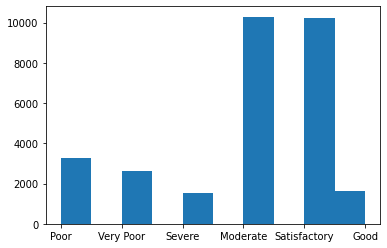

In [86]:
# Import the relevant Python libraries.
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Convert sex to an array using Numpy and plot it using pyplot. 
sexArr = np.array(train1.select('AQIBucket').collect())
plt.hist(sexArr)
plt.show()


In [87]:
# Not all interpretation has to be visualisations. You can also gain a lot of information with text.
# For example, here we're seeing how much variance our model could account for.
# According to this, the model got 164/209 correct. 
totalResults = results.select('AQIB_index','prediction')


correctResults = totalResults.filter(totalResults['AQIB_INDEX'] == totalResults['prediction'])

countTR = totalResults.count()
print("Correct: " + str(countTR))

countTC = correctResults.count()
print("Total Correct: " + str(countTC)) 

Correct: 9002


Total Correct: 6102


In [88]:
spark_df_filled3.show()

+---------+----------+------+------+--------+---------+---------+-----+---------+----+-----+
|     City|      Date|  PM25|  PM10|     NO2|      SO2|       O3|  AQI|AQIBucket|year| AQII|
+---------+----------+------+------+--------+---------+---------+-----+---------+----+-----+
|Ahmedabad|2015-07-24| 29.22|141.54|    9.57|    13.58|     5.08| 48.0|     Good|2015| 48.0|
|Ahmedabad|2015-02-05| 58.36|141.54|   21.39|    32.66|    53.54|149.0| Moderate|2015|149.0|
|Ahmedabad|2015-02-06| 79.29|141.54|   26.94|    67.41|     59.3|190.0| Moderate|2015|190.0|
|Ahmedabad|2015-02-26| 61.12|141.54|28.56066|14.531978|34.491432| null| Moderate|2015|189.0|
|Ahmedabad|2015-02-27| 61.12|141.54|28.56066|14.531978|34.491432| null| Moderate|2015|189.0|
|Ahmedabad|2015-02-28| 61.12|141.54|28.56066|14.531978|34.491432| null| Moderate|2015|189.0|
|Ahmedabad|2015-03-01| 61.12|141.54|   16.81|    28.44|    30.48| null| Moderate|2015|189.0|
|Ahmedabad|2015-03-02| 60.78|141.54|   18.21|    29.48|    34.75|189.0

In [89]:
# prepare the data
features = ["PM25","PM10","NO2","SO2","O3"]
lr_data = spark_df_filled3.select(col("AQII").alias("label"), *features)
lr_data.printSchema()

# split the dataset into training and test
(training, test) = lr_data.randomSplit([.7, .3], seed = 196)



root
 |-- label: float (nullable = true)
 |-- PM25: float (nullable = true)
 |-- PM10: float (nullable = false)
 |-- NO2: float (nullable = false)
 |-- SO2: float (nullable = false)
 |-- O3: float (nullable = false)



In [90]:
# creating the pipeline
vectorAssembler = VectorAssembler(inputCols=features, outputCol="unscaled_features")
standardScaler = StandardScaler(inputCol="unscaled_features", outputCol="features")
lr = LinearRegression(maxIter=10, regParam=.01)

estimators = [vectorAssembler, standardScaler, lr]


# building the model using the pipeline
# https://spark.apache.org/docs/latest/api/python/pyspark.ml.html#pyspark.ml.Pipeline
pipeline = Pipeline(stages=estimators)

model = pipeline.fit(training)


In [91]:
# prediction
prediction = model.transform(test)

prediction.show()



+-----+-----+-----+--------+---------+---------+--------------------+--------------------+------------------+
|label| PM25| PM10|     NO2|      SO2|       O3|   unscaled_features|            features|        prediction|
+-----+-----+-----+--------+---------+---------+--------------------+--------------------+------------------+
| 14.0|10.04|18.31|28.56066|14.531978|34.491432|[10.0399999618530...|[0.13868913291709...| 89.90256045948512|
| 14.0|10.04|18.31|28.56066|14.531978|34.491432|[10.0399999618530...|[0.13868913291709...| 89.90256045948512|
| 14.0| 11.4| 34.2|28.56066|    14.96|    19.58|[11.3999996185302...|[0.15747570401956...| 96.34530020869393|
| 14.0|13.06|15.75|28.56066|14.531978|34.491432|[13.0600004196167...|[0.18040638854338...| 91.37151738879173|
| 14.0|13.06|15.75|28.56066|14.531978|34.491432|[13.0600004196167...|[0.18040638854338...| 91.37151738879173|
| 14.0|13.06|15.75|28.56066|14.531978|34.491432|[13.0600004196167...|[0.18040638854338...| 91.37151738879173|
| 14.0|13.

In [92]:
# evaluate the model
from pyspark.ml.evaluation import RegressionEvaluator
eval = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")

# Root Mean Square Error

rmse = eval.evaluate(prediction)
print("RMSE: %.3f" % rmse)

# Mean Square Error

mse = eval.evaluate(prediction, {eval.metricName: "mse"})
print("MSE: %.3f" % mse)

# Mean Absolute Error

mae = eval.evaluate(prediction, {eval.metricName: "mae"})
print("MAE: %.3f" % mae)

# r2 - coefficient of determination

r2 = eval.evaluate(prediction, {eval.metricName: "r2"})
print("r2: %.3f" %r2)

RMSE: 91.995


MSE: 8463.011


MAE: 51.722


r2: 0.553


In [93]:
spark_df_filled3.show()

+---------+----------+------+------+--------+---------+---------+-----+---------+----+-----+
|     City|      Date|  PM25|  PM10|     NO2|      SO2|       O3|  AQI|AQIBucket|year| AQII|
+---------+----------+------+------+--------+---------+---------+-----+---------+----+-----+
|Ahmedabad|2015-07-24| 29.22|141.54|    9.57|    13.58|     5.08| 48.0|     Good|2015| 48.0|
|Ahmedabad|2015-02-05| 58.36|141.54|   21.39|    32.66|    53.54|149.0| Moderate|2015|149.0|
|Ahmedabad|2015-02-06| 79.29|141.54|   26.94|    67.41|     59.3|190.0| Moderate|2015|190.0|
|Ahmedabad|2015-02-26| 61.12|141.54|28.56066|14.531978|34.491432| null| Moderate|2015|189.0|
|Ahmedabad|2015-02-27| 61.12|141.54|28.56066|14.531978|34.491432| null| Moderate|2015|189.0|
|Ahmedabad|2015-02-28| 61.12|141.54|28.56066|14.531978|34.491432| null| Moderate|2015|189.0|
|Ahmedabad|2015-03-01| 61.12|141.54|   16.81|    28.44|    30.48| null| Moderate|2015|189.0|
|Ahmedabad|2015-03-02| 60.78|141.54|   18.21|    29.48|    34.75|189.0

In [94]:
assembler = VectorAssembler(inputCols=['PM25',
 'PM10',
 'NO2',
 'SO2',
 'O3','AQII'],outputCol="features")

# Let's transform the data. 
output = assembler.transform(spark_df_filled3)

# Let's select the two columns we want. Features (which contains vectors), and the predictor.
indexer = StringIndexer(inputCol="AQIBucket", outputCol="AQIB_index")
output_fixed = indexer.fit(output).transform(output)

In [95]:
#output.show()
spark_df_ind.show()

+---------+----------+------+------+--------+---------+---------+-----+---------+----+-----+----------+
|     City|      Date|  PM25|  PM10|     NO2|      SO2|       O3|  AQI|AQIBucket|year| AQII|AQIB_index|
+---------+----------+------+------+--------+---------+---------+-----+---------+----+-----+----------+
|Ahmedabad|2015-07-24| 29.22|141.54|    9.57|    13.58|     5.08| 48.0|     Good|2015| 48.0|       4.0|
|Ahmedabad|2015-02-05| 58.36|141.54|   21.39|    32.66|    53.54|149.0| Moderate|2015|149.0|       0.0|
|Ahmedabad|2015-02-06| 79.29|141.54|   26.94|    67.41|     59.3|190.0| Moderate|2015|190.0|       0.0|
|Ahmedabad|2015-02-26| 61.12|141.54|28.56066|14.531978|34.491432| null| Moderate|2015|189.0|       0.0|
|Ahmedabad|2015-02-27| 61.12|141.54|28.56066|14.531978|34.491432| null| Moderate|2015|189.0|       0.0|
|Ahmedabad|2015-02-28| 61.12|141.54|28.56066|14.531978|34.491432| null| Moderate|2015|189.0|       0.0|
|Ahmedabad|2015-03-01| 61.12|141.54|   16.81|    28.44|    30.48

In [96]:
###AQIB_index

# Now we can assemble all of this as one vector in the features column. 


# Let's select the two columns we want. Features (which contains vectors), and the predictor.

final_data = output_fixed.select('features','AQIB_index')

# Split the training and testing set.
train_data,test_data = final_data.randomSplit([0.7,0.3])

# Let's import the relevant classifiers. 
from pyspark.ml.classification import DecisionTreeClassifier,GBTClassifier,RandomForestClassifier
from pyspark.ml import Pipeline

# Use defaults to make the comparison "fair". This simplifies the comparison process.

dtc = DecisionTreeClassifier(labelCol='AQIB_index',featuresCol='features')
rfc = RandomForestClassifier(labelCol='AQIB_index',featuresCol='features')
gbt = GBTClassifier(labelCol='AQIB_index',featuresCol='features')

# Train the models (it's three models, so it might take some time).
dtc_model = dtc.fit(train_data)
rfc_model = rfc.fit(train_data)
#gbt_model = gbt.fit(train_data)

dtc_predictions = dtc_model.transform(test_data)
rfc_predictions = rfc_model.transform(test_data)
#gbt_predictions = gbt_model.transform(test_data)

In [97]:
# Let's start off with binary classification.
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Note that the label column isn't named label, it's named PrivateIndex in this case.
my_binary_eval = BinaryClassificationEvaluator(rawPredictionCol='prediction',
                                       labelCol='AQIB_index')

# This is the area under the curve. This indicates that the data is highly seperable.
print("DTC")
print(my_binary_eval.evaluate(dtc_predictions))

# RFC improves accuracy but also model complexity. RFC outperforms DTC in nearly every situation.
print("RFC")
print(my_binary_eval.evaluate(rfc_predictions))


DTC


0.9873986405124457
RFC


0.9927191853219763


# kmeans unsupervised learning

In [98]:
import pandas as pd

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans
from pyspark.ml import Pipeline

assembler = VectorAssembler(inputCols=['PM25',
 'PM10',
 'NO2',
 'SO2',
 'O3','AQII'],outputCol="features")

spark_df_indk=spark_df_ind
spark_df_indk=spark_df_indk.drop("AQIB_index")

assembled_data=assembler.transform(spark_df_indk)
assembled_data.show(2)


+---------+----------+-----+------+-----+-----+-----+-----+---------+----+-----+--------------------+
|     City|      Date| PM25|  PM10|  NO2|  SO2|   O3|  AQI|AQIBucket|year| AQII|            features|
+---------+----------+-----+------+-----+-----+-----+-----+---------+----+-----+--------------------+
|Ahmedabad|2015-07-24|29.22|141.54| 9.57|13.58| 5.08| 48.0|     Good|2015| 48.0|[29.2199993133544...|
|Ahmedabad|2015-02-05|58.36|141.54|21.39|32.66|53.54|149.0| Moderate|2015|149.0|[58.3600006103515...|
+---------+----------+-----+------+-----+-----+-----+-----+---------+----+-----+--------------------+
only showing top 2 rows



In [99]:

#from pyspark.ml.feature import StandardScaler
#scale=StandardScaler(inputCol='features',outputCol='standardized')
#data_scale=scale.fit(assembled_data)
#data_scale_output=data_scale.transform(assembled_data)
#data_scale_output.show(2)

Silhouette Score: 0.7417176461544878


Silhouette Score: 0.662418277587624


Silhouette Score: 0.5963458682942219


Silhouette Score: 0.5177992096227876


Silhouette Score: 0.5379994840142674


Silhouette Score: 0.5408080333570792


Silhouette Score: 0.5411449274957548


Silhouette Score: 0.5082355145056396


Text(0, 0.5, 'cost')

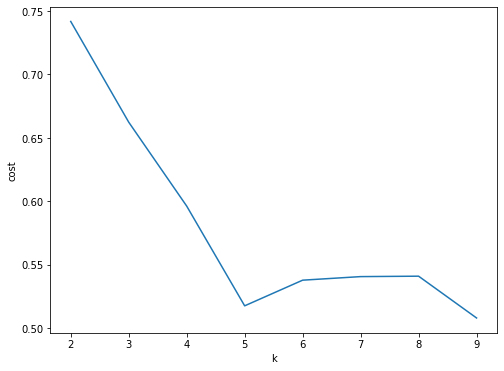

In [100]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
silhouette_score=[]

evaluator = ClusteringEvaluator(featuresCol='features', \
metricName='silhouette', distanceMeasure='squaredEuclidean')

#evaluator = ClusteringEvaluator( featuresCol='standardized', \
#                                metricName='silhouette', distanceMeasure='squaredEuclidean')
for i in range(2,10):
    
    KMeans_algo=KMeans(featuresCol='features', k=i)
    
    KMeans_fit=KMeans_algo.fit(assembled_data)
    
    output=KMeans_fit.transform(assembled_data)
    
    
    
    score=evaluator.evaluate(output)
    
    silhouette_score.append(score)
    
    print("Silhouette Score:",score)
    
    
#Visualizing the silhouette scores in a plot
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,10),silhouette_score)
ax.set_xlabel('k')
ax.set_ylabel('cost')

In [101]:
KMeans_=KMeans(featuresCol='features', k=5) 
KMeans_Model=KMeans_.fit(assembled_data)
KMeans_Assignments=KMeans_Model.transform(assembled_data)
KMeans_Assignments



DataFrame[City: string, Date: string, PM25: float, PM10: float, NO2: float, SO2: float, O3: float, AQI: float, AQIBucket: string, year: int, AQII: float, features: vector, prediction: int]

In [ ]:
KMeans_Assignments.groupBy("prediction").count().show()
KMeans_Assignments.show()
model.predict(df.head().features)

In [107]:
from pyspark.ml.linalg import Vectors

numCols = ['PM25','PM10','NO2','SO2','O3']
target = ['AQIB_Index']

y_kmeans = KMeans_Model.predict(assembled_data)



+----------+-----+
|prediction|count|
+----------+-----+
|         1| 1801|
|         3|14769|
|         4| 3925|
|         2|  234|
|         0| 8802|
+----------+-----+



+---------+----------+------+------+--------+---------+---------+-----+---------+----+-----+--------------------+----------+
|     City|      Date|  PM25|  PM10|     NO2|      SO2|       O3|  AQI|AQIBucket|year| AQII|            features|prediction|
+---------+----------+------+------+--------+---------+---------+-----+---------+----+-----+--------------------+----------+
|Ahmedabad|2015-07-24| 29.22|141.54|    9.57|    13.58|     5.08| 48.0|     Good|2015| 48.0|[29.2199993133544...|         3|
|Ahmedabad|2015-02-05| 58.36|141.54|   21.39|    32.66|    53.54|149.0| Moderate|2015|149.0|[58.3600006103515...|         0|
|Ahmedabad|2015-02-06| 79.29|141.54|   26.94|    67.41|     59.3|190.0| Moderate|2015|190.0|[79.2900009155273...|         0|
|Ahmedabad|2015-02-26| 61.12|141.54|28.56066|14.531978|34.491432| null| Moderate|2015|189.0|[61.1199989318847...|         0|
|Ahmedabad|2015-02-27| 61.12|141.54|28.56066|14.531978|34.491432| null| Moderate|2015|189.0|[61.1199989318847...|         0|


Py4JError: An error occurred while calling o3943.predict. Trace:
py4j.Py4JException: Method predict([class org.apache.spark.sql.Dataset]) does not exist
	at py4j.reflection.ReflectionEngine.getMethod(ReflectionEngine.java:318)
	at py4j.reflection.ReflectionEngine.getMethod(ReflectionEngine.java:326)
	at py4j.Gateway.invoke(Gateway.java:274)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:829)



In [105]:
KMeans_Assignments.groupBy("AQIBucket","prediction").count().show()

+------------+----------+-----+
|   AQIBucket|prediction|count|
+------------+----------+-----+
|    Moderate|         3| 3737|
|Satisfactory|         0|  749|
|   Very Poor|         1|  867|
|        Poor|         1|  319|
|    Moderate|         0| 6513|
|      Severe|         2|  234|
|Satisfactory|         1|   16|
|      Severe|         4|  723|
|Satisfactory|         4|   10|
|        Poor|         0| 1496|
|   Very Poor|         4| 1761|
|Satisfactory|         3| 9462|
|    Moderate|         4|    1|
|        Poor|         4| 1430|
|        Good|         3| 1567|
|        Good|         0|   44|
|      Severe|         1|  555|
|    Moderate|         1|   44|
|        Poor|         3|    3|
+------------+----------+-----+



In [ ]:
plt.scatter(assembled_data[:, 0], assembled_data[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

In [1]:
KMeans_=KMeans(featuresCol='features', k=5) 
KMeans_Model=KMeans_.fit(assembled_data)
KMeans_Assignments=KMeans_Model.transform(assembled_data)

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from pyspark.ml.feature import PCA as PCAml
pca = PCAml(k=5, inputCol="features", outputCol="pca")
pca_model = pca.fit(assembled_data)
pca_transformed = pca_model.transform(assembled_data)







NameError: name 'KMeans' is not defined

In [107]:
import numpy as np
x_pca = np.array(pca_transformed.rdd.map(lambda row: row.pca).collect())

cluster_assignment = np.array(KMeans_Assignments.rdd.map(lambda row: row.prediction).collect()).reshape(-1,1)






In [109]:
pca_data = np.hstack((x_pca,cluster_assignment))

ValueError: Supply a 'c' argument or a 'color' kwarg but not both; they differ but their functionalities overlap.

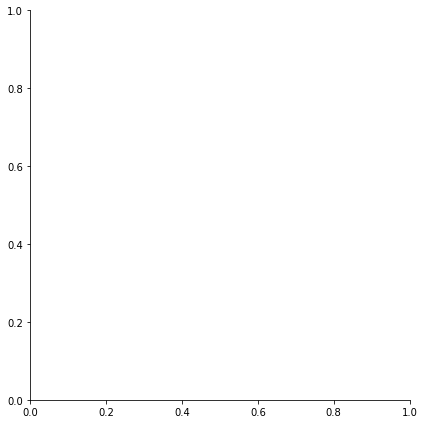

In [112]:
import seaborn as sns
import matplotlib.pyplot as plt



pca_df = pd.DataFrame(data=pca_data, columns=("1", "2","3","4","5","cluster1"))
sns.FacetGrid(pca_df,hue="cluster1", height=6).map(plt.scatter, '1', '2','3','4','5' ).add_legend()

plt.show()

# Reformat and view results
loadings = pandas.DataFrame(pca_data,
columns=['PC%s' % _ for _ in range(len(df_normalized.columns))],
index=df.columns)
print(loadings)

plot.plot(pca.explained_variance_ratio_)
plot.ylabel('Explained Variance')
plot.xlabel('Components')
plot.show()




In [110]:
pca_data


array([[-107.63887621,  103.40503395,   32.35565438,   -5.25450014,
           3.8186902 ,    0.        ],
       [-206.30646546,   61.04307343,   28.28880436,  -42.11256801,
         -25.61568517,    3.        ],
       [-250.34367011,   44.45052225,   18.65370352,  -55.04555487,
         -20.62821161,    3.        ],
       ...,
       [-358.0330861 ,   -2.81806213,    4.84781684,  -51.39542837,
          16.40874459,    4.        ],
       [-380.86561543,   42.14086501,   33.01824176,  -46.00495082,
          -2.85215285,    4.        ],
       [-472.75461535,  159.45115553,   20.98572926,  -55.80149907,
           8.00440226,    2.        ]])

In [127]:


from sklearn.manifold import TSNE

tSNE=TSNE(n_components=2)
tSNE_result=tSNE.fit_transform(assembled_data)

x=tSNE_result[:,0]
y=tSNE_result[:,1]

import pandas as pd
import seaborn as sns


numCols = ['PM25','PM10','NO2','SO2','O3']
target = ['AQIB_Index']


df = pd.DataFrame(data=assembled_data,columns=numCols)
df['target']=target
df['x']=x
df['y']=y

plt.figure(figsize=(16,7))
sns.scatterplot(x='x',y='y',hue='target',palette=sns.color_palette("hls",10),data=df,
               legend="full")
plt.show()



ModuleNotFoundError: No module named 'sklearn'

In [128]:
pca_data

array([[-107.63887621,  103.40503395,    1.        ],
       [-206.30646546,   61.04307343,    4.        ],
       [-250.34367011,   44.45052225,    4.        ],
       ...,
       [-358.0330861 ,   -2.81806213,    2.        ],
       [-380.86561543,   42.14086501,    2.        ],
       [-472.75461535,  159.45115553,    0.        ]])

TypeError: 'DataFrame' object is not callable